In [1]:
# Importiamo tutte le librerie
# Librerie destinate a capire se la scheda video è stata individuata
from distutils.version import LooseVersion
import warnings
# TensorFlow è una libreria software open source usata nell'apprendimento automatico
import tensorflow as tf
# Pandas è una libreria destinata all'analisi dati comprendente un numeroso numero di funzioni
import pandas as pd
# Numpy è una libreria destana al calcolo vettoriale e matriciale
import numpy as np
# Matplotlib è una libreria per la creazione di grafici
import matplotlib.pyplot as plt

#Librerie necessarie per la realizzazione del modello 
from numpy import  newaxis
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras import activations
from tensorflow.keras import optimizers
optimizers.RMSprop
optimizers.Adam

# Necessarie per l'inizializzazione dei pesi
import random as rn
import os

In [2]:
# Verifichiamo che la GPU sia montata correttamente e controlliamo la versione di Tensorflow installata

assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 2.6.0
Default GPU Device: /device:GPU:0


In [3]:
# Rimuoviamo gli eventi randomici, inizializzando i pesi

os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
np.random.seed(37)
rn.seed(1254)
tf.random.set_seed(89)

In [4]:
# Importiamo i dataset

test = "C://Users//simon//OneDrive//Desktop//Università//Machine Learning//task2_anomaly_detection//ad_test.csv"
train = "C://Users//simon//OneDrive//Desktop//Università//Machine Learning//task2_anomaly_detection//ad_train.csv"
train = pd.read_csv(train)
test = pd.read_csv(test)
print(train.shape)
print(test.shape)

(943522, 7)
(722787, 7)


In [5]:
# Riordiniamo le colonne di test
cols = list(test.columns)
b,c,d,e,f,g = cols.index('x'), cols.index('y'), cols.index('z'), cols.index('heartRate'), cols.index('timestamp'), cols.index('tsDate')
cols[f],cols[g],cols[b],cols[c],cols[d],cols[e]= cols[b], cols[c], cols[d], cols[e], cols[f], cols[g]
test = test[cols]

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943522 entries, 0 to 943521
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   patient    943522 non-null  int64 
 1   x          943522 non-null  int64 
 2   y          943522 non-null  int64 
 3   z          943522 non-null  int64 
 4   heartRate  943522 non-null  int64 
 5   timestamp  943522 non-null  int64 
 6   tsDate     943522 non-null  object
dtypes: int64(6), object(1)
memory usage: 50.4+ MB


In [7]:
train.head()

patient   x    y    z  heartRate      timestamp                   tsDate
0     1502  23  569  878         -1  1568073600000  2019-09-10 00:00:00.003
1     1502  23  571  878         -1  1568073601000  2019-09-10 00:00:01.014
2     1502  23  570  878         -1  1568073602000  2019-09-10 00:00:02.025
3     1502  23  570  878         -1  1568073603000  2019-09-10 00:00:03.035
4     1502  23  570  878         -1  1568073604000  2019-09-10 00:00:04.046

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 722787 entries, 0 to 722786
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   patient    722787 non-null  int64 
 1   x          722787 non-null  int64 
 2   y          722787 non-null  int64 
 3   z          722787 non-null  int64 
 4   heartRate  722787 non-null  int64 
 5   timestamp  722787 non-null  int64 
 6   tsDate     722787 non-null  object
dtypes: int64(6), object(1)
memory usage: 38.6+ MB


In [9]:
test.head()

patient    x    y    z  heartRate      timestamp                   tsDate
0     1004  -24  749 -626         77  1567224000000  2019-08-31 04:00:00.004
1     1004 -206  930  -63         77  1567224010000  2019-08-31 04:00:10.022
2     1004 -139  763 -577         72  1567224020000  2019-08-31 04:00:20.041
3     1004 -503  441 -557         73  1567224030000  2019-08-31 04:00:30.059
4     1004 -278  705 -396         78  1567224040000  2019-08-31 04:00:40.060

In [10]:
# In tale cella vengono visualizzati i pazienti da analizzare nel test set ed il loro relativo indice

patient_test=[]
location_test=[]
patient_test.append(1004)

for i in range(0,len(test),1):
    if(test['patient'][i]!=patient_test[len(patient_test)-1]):
        patient_test.append(test['patient'][i])
        location_test.append(i)
        
print("In the test set  we have ",len(patient_test),"patient, that we identify like " ,patient_test)

In the test set  we have  5 patient, that we identify like  [1004, 1006, 3001, 3006, 4002]


In [11]:
#Vengono droppate le righe con HeartRate=-1
dropped_train=pd.DataFrame(columns=('heartRate', 'x', 'y', 'z'))
dropped_train = train[train.heartRate != -1].reset_index(drop=True)
#VEDERE

In [12]:
#Viene fatta la media ogni 10 valori e salvata in average_train
average_train=pd.DataFrame(columns=('heartRate', 'x', 'y', 'z'))
average_train = dropped_train.groupby(np.arange(len(dropped_train))//10).mean()


In [14]:
# Definiamo i singoli dataset su cui lavorare
#L'indice di ogni dataframe viene azzerato

test_x_0 = test[:location_test[0]].reset_index(drop=True)
test_x_1 = test[location_test[0]:location_test[1]].reset_index(drop=True)
test_x_2 = test[location_test[1]:location_test[2]].reset_index(drop=True)
test_x_3 = test[location_test[2]:location_test[3]].reset_index(drop=True)
test_x_4 = test[location_test[3]:].reset_index(drop=True)

In [16]:
# Normalizziamo il dataset
#La normalizzazione viene fata in modo che i dati di train siano tutti in un range [0,1]
#Poi i parametri utilizzati per i dati di train vengono applicati a quelli di test, per mantenere la stessa metrica

minimo_train_heartRate = min (average_train['heartRate'].values)
minimo_train_x = min (average_train['x'].values)
minimo_train_y = min (average_train['y'].values)
minimo_train_z = min (average_train['z'].values)

average_train['heartRate']= average_train['heartRate'].add(-minimo_train_heartRate)#- minimo_train_heartRate)
average_train['x'] = average_train['x'].add(-minimo_train_x)
average_train['y'] = average_train['y'].add(-minimo_train_y)
average_train['z'] = average_train['z'].add(-minimo_train_z)

massimo_train_heartRate = max (average_train['heartRate'].values)
massimo_train_x = max (average_train['x'].values)
massimo_train_y = max (average_train['y'].values)
massimo_train_z = max (average_train['z'].values)

average_train['heartRate'] = average_train['heartRate'].div(massimo_train_heartRate)
average_train['x'] = average_train['x'].div(massimo_train_x)
average_train['y'] = average_train['y'].div(massimo_train_y)
average_train['z'] = average_train['z'].div(massimo_train_z)



test_x_0['heartRate'] = test_x_0['heartRate'].add(-minimo_train_heartRate).div(massimo_train_heartRate)
test_x_0['x'] = test_x_0['x'].add(- minimo_train_x).div(massimo_train_x)
test_x_0['y'] = test_x_0['y'].add(- minimo_train_y).div(massimo_train_y)
test_x_0['z'] = test_x_0['z'].add(- minimo_train_z).div(massimo_train_z)

test_x_1['heartRate'] = test_x_1['heartRate'].add(-minimo_train_heartRate).div(massimo_train_heartRate)
test_x_1['x'] = test_x_1['x'].add(- minimo_train_x).div(massimo_train_x)
test_x_1['y'] = test_x_1['y'].add(- minimo_train_y).div(massimo_train_y)
test_x_1['z'] = test_x_1['z'].add(- minimo_train_z).div(massimo_train_z)

test_x_2['heartRate'] = test_x_2['heartRate'].add(-minimo_train_heartRate).div(massimo_train_heartRate)
test_x_2['x'] = test_x_2['x'].add(- minimo_train_x).div(massimo_train_x)
test_x_2['y'] = test_x_2['y'].add(- minimo_train_y).div(massimo_train_y)
test_x_2['z'] = test_x_2['z'].add(- minimo_train_z).div(massimo_train_z)

test_x_3['heartRate'] = test_x_3['heartRate'].add(-minimo_train_heartRate).div(massimo_train_heartRate)
test_x_3['x'] = test_x_3['x'].add(- minimo_train_x).div(massimo_train_x)
test_x_3['y'] = test_x_3['y'].add(- minimo_train_y).div(massimo_train_y)
test_x_3['z'] = test_x_3['z'].add(- minimo_train_z).div(massimo_train_z)

test_x_4['heartRate'] = test_x_4['heartRate'].add(-minimo_train_heartRate).div(massimo_train_heartRate)
test_x_4['x'] = test_x_4['x'].add(- minimo_train_x).div(massimo_train_x)
test_x_4['y'] = test_x_4['y'].add(- minimo_train_y).div(massimo_train_y)
test_x_4['z'] = test_x_4['z'].add(- minimo_train_z).div(massimo_train_z)

print(max(test_x_0['heartRate']))
print(max(test_x_0['x']))
print(max(test_x_0['y']))
print(max(test_x_0['z']))

0.8009810791871058
0.9181520262169292
0.9714866675909237
0.9754961903866053


In [17]:
lookback = 60

In [18]:
# Tramite il generator è possibile definire i tensori necessarari nel modello
def generator(data, paziente, lookback):
    samples = []

    for i in range(len(data['heartRate']) - lookback):
#Aggiungiamo un if al fine di considerare sequenze che contengono dati di un solo paziente alla volta
         if(paziente[i] == paziente[i+lookback]):
            samples.append(data[i : (i + lookback)])
    return np.stack(samples)

In [19]:
x_train = generator(average_train[['heartRate','x','y','z']],average_train['patient'], lookback = lookback)

x_test_0 = generator(test_x_0[['heartRate','x','y','z']],test_x_0['patient'], lookback = lookback)
x_test_1 = generator(test_x_1[['heartRate','x','y','z']],test_x_1['patient'], lookback = lookback)
x_test_2 = generator(test_x_2[['heartRate','x','y','z']],test_x_2['patient'], lookback = lookback)
x_test_3 = generator(test_x_3[['heartRate','x','y','z']],test_x_3['patient'], lookback = lookback)
x_test_4 = generator(test_x_4[['heartRate','x','y','z']],test_x_4['patient'], lookback = lookback)

In [20]:
print(x_train.shape)
print(x_test_0.shape)
print(x_test_1.shape)
print(x_test_2.shape)
print(x_test_3.shape)

(89659, 60, 4)
(144851, 60, 4)
(148311, 60, 4)
(188844, 60, 4)
(109835, 60, 4)


In [21]:
# Definiamo il modello
model = Sequential()
model.add(layers.GRU(64, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(layers.Dense(64))
model.add(layers.Dense(64))
model.add(layers.Dense(64))
model.add(layers.Dense(64))
model.add(layers.RepeatVector(x_train.shape[1]))
model.add(layers.Dense(64))
model.add(layers.Dense(64))
model.add(layers.Dense(64))
model.add(layers.Dense(64))
model.add(layers.GRU(64, return_sequences=True))
model.add(layers.TimeDistributed(Dense(x_train.shape[2])))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mae")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 64)                13440     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 60, 64)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 60, 64)            4

In [22]:
# Effettuiamo un fit dei dati di train
history = model.fit(x_train, x_train,validation_split=0.1,epochs=150, batch_size=128)

Epoch 1/150
631/631 [==============================] - 12s 12ms/step - loss: 0.0773 - val_loss: 0.0677
Epoch 2/150
631/631 [==============================] - 7s 11ms/step - loss: 0.0675 - val_loss: 0.0654
Epoch 3/150
631/631 [==============================] - 7s 11ms/step - loss: 0.0639 - val_loss: 0.0634
Epoch 4/150
631/631 [==============================] - 7s 11ms/step - loss: 0.0617 - val_loss: 0.0585
Epoch 5/150
631/631 [==============================] - 7s 11ms/step - loss: 0.0567 - val_loss: 0.0552
Epoch 6/150
631/631 [==============================] - 7s 11ms/step - loss: 0.0544 - val_loss: 0.0525
Epoch 7/150
631/631 [==============================] - 7s 11ms/step - loss: 0.0526 - val_loss: 0.0514
Epoch 8/150
631/631 [==============================] - 7s 12ms/step - loss: 0.0510 - val_loss: 0.0515
Epoch 9/150
631/631 [==============================] - 7s 11ms/step - loss: 0.0496 - val_loss: 0.0490
Epoch 10/150
631/631 [==============================] - 7s 12ms/step - loss: 0.04

631/631 [==============================] - 8s 12ms/step - loss: 0.0318 - val_loss: 0.0308
Epoch 81/150
631/631 [==============================] - 7s 12ms/step - loss: 0.0317 - val_loss: 0.0313
Epoch 82/150
631/631 [==============================] - 8s 12ms/step - loss: 0.0317 - val_loss: 0.0315
Epoch 83/150
631/631 [==============================] - 8s 13ms/step - loss: 0.0316 - val_loss: 0.0305
Epoch 84/150
631/631 [==============================] - 8s 12ms/step - loss: 0.0314 - val_loss: 0.0309
Epoch 85/150
631/631 [==============================] - 8s 12ms/step - loss: 0.0314 - val_loss: 0.0304
Epoch 86/150
631/631 [==============================] - 8s 12ms/step - loss: 0.0313 - val_loss: 0.0303
Epoch 87/150
631/631 [==============================] - 8s 12ms/step - loss: 0.0311 - val_loss: 0.0306
Epoch 88/150
631/631 [==============================] - 8s 12ms/step - loss: 0.0311 - val_loss: 0.0300
Epoch 89/150
631/631 [==============================] - 7s 12ms/step - loss: 0.0309 - 

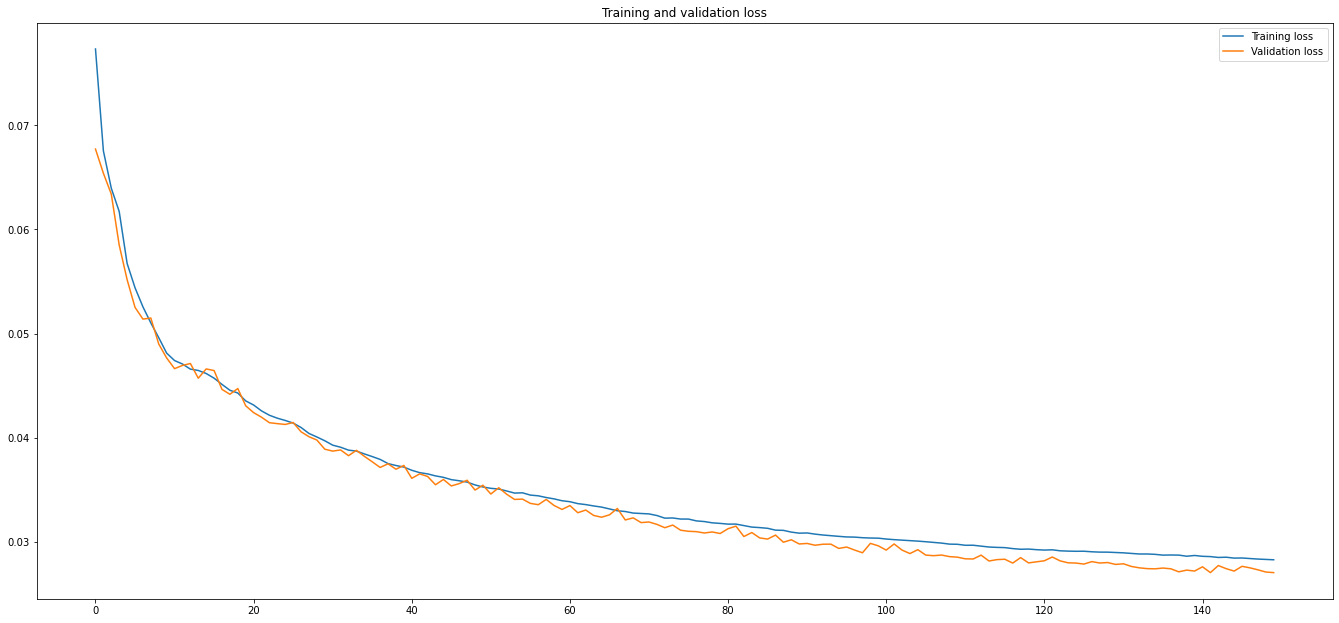

In [23]:
# Plottiamo training loss e validation loss
fig = plt.figure()
ax = fig.add_axes([1,10,3,2])
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.legend();

In [24]:
# Calcoliamo la MAE di train
x_train_pred = model.predict(x_train)
#Viene calcolata su ogni step temporale, come differenza tra i dati ricostruiti e quelli reali
train_mae_loss = (x_train_pred - x_train).reshape(-1,lookback*4)
train_mae_loss = np.mean(np.abs(train_mae_loss), axis=1)
train_mae_loss.shape

(89659,)

In [25]:
# Definiamo il valore massimo della mae di train come ref_value_0 e consideriamo l'80% di tale valore
ref_value_0 = np.max(train_mae_loss[:])*0.8

Text(0, 0.5, 'Number of points')

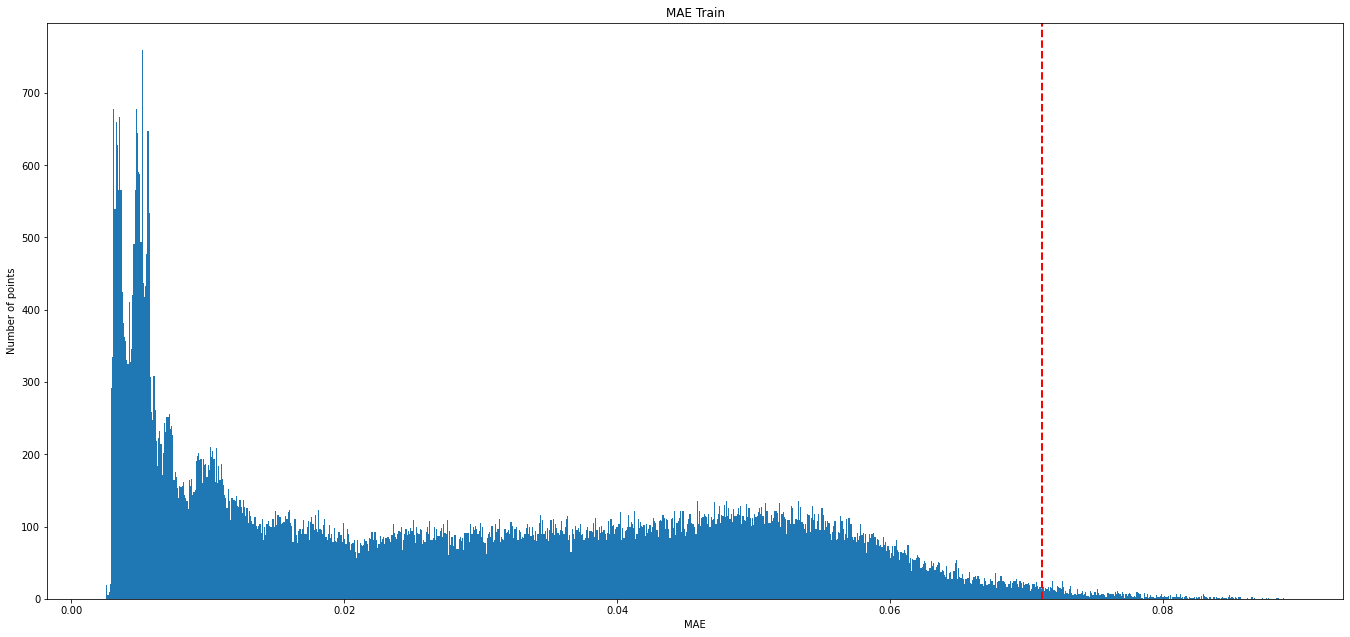

In [26]:
fig = plt.figure()
ax = fig.add_axes([1,10,3,2])
plt.hist(train_mae_loss[:], bins =1000)
plt.axvline(ref_value_0 , color='r', linestyle='dashed', linewidth=2)
plt.title('MAE Train')
plt.xlabel('MAE')
plt.ylabel('Number of points')

In [27]:
# calcoliamo la MAE di test come fatto per quella di train
x_test_pred_0 = model.predict(x_test_0)
test_mae_loss_0 = (x_test_pred_0 - x_test_0).reshape(-1,lookback*4)
test_mae_loss_0 = np.mean(np.abs(test_mae_loss_0), axis=1)

x_test_pred_1 = model.predict(x_test_1)
test_mae_loss_1 = (x_test_pred_1 - x_test_1).reshape(-1,lookback*4)
test_mae_loss_1 = np.mean(np.abs(test_mae_loss_1), axis=1)

x_test_pred_2 = model.predict(x_test_2)
test_mae_loss_2 = (x_test_pred_2 - x_test_2).reshape(-1,lookback*4)
test_mae_loss_2 = np.mean(np.abs(test_mae_loss_2), axis=1)

x_test_pred_3 = model.predict(x_test_3)
test_mae_loss_3 = (x_test_pred_3 - x_test_3).reshape(-1,lookback*4)
test_mae_loss_3 = np.mean(np.abs(test_mae_loss_3), axis=1)

x_test_pred_4 = model.predict(x_test_4)
test_mae_loss_4 = (x_test_pred_4 - x_test_4).reshape(-1,lookback*4)
test_mae_loss_4 = np.mean(np.abs(test_mae_loss_4), axis=1)


Text(0, 0.5, 'Number of points')

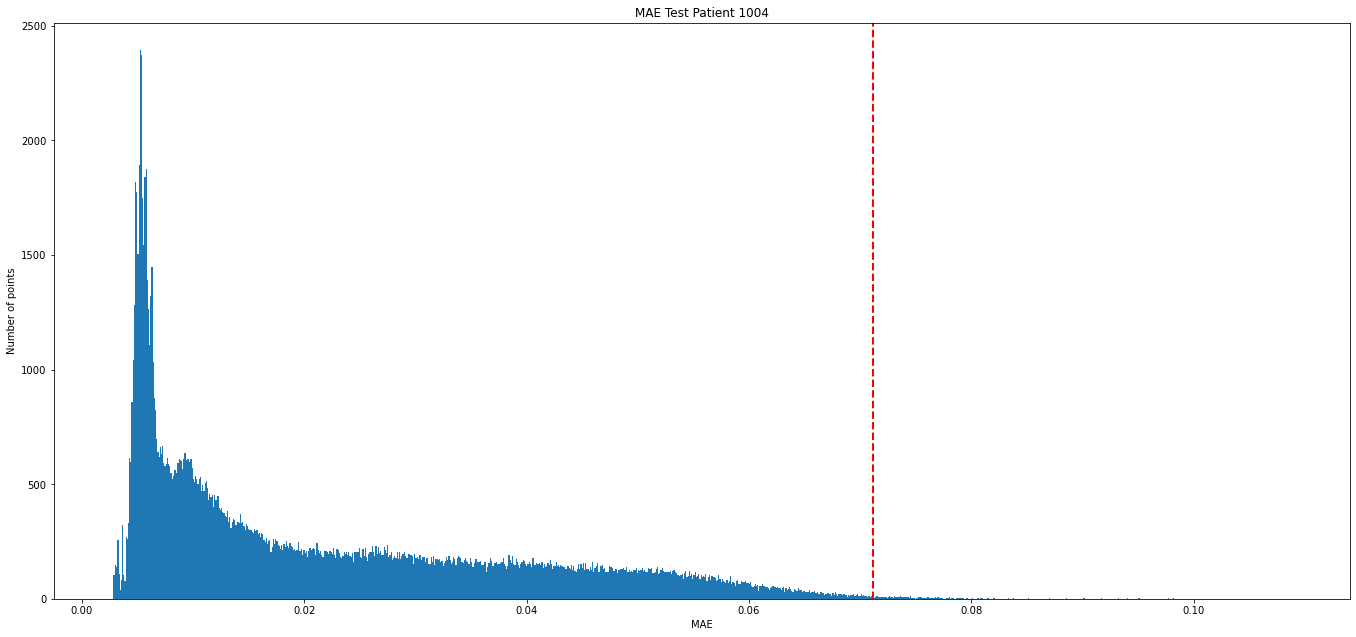

In [28]:
fig = plt.figure()
ax = fig.add_axes([1,10,3,2])

plt.hist(test_mae_loss_0, bins =1000)
plt.axvline(ref_value_0 , color='r', linestyle='dashed', linewidth=2)
plt.title('MAE Test Patient 1004')
plt.xlabel('MAE')
plt.ylabel('Number of points')

Text(0, 0.5, 'Number of points')

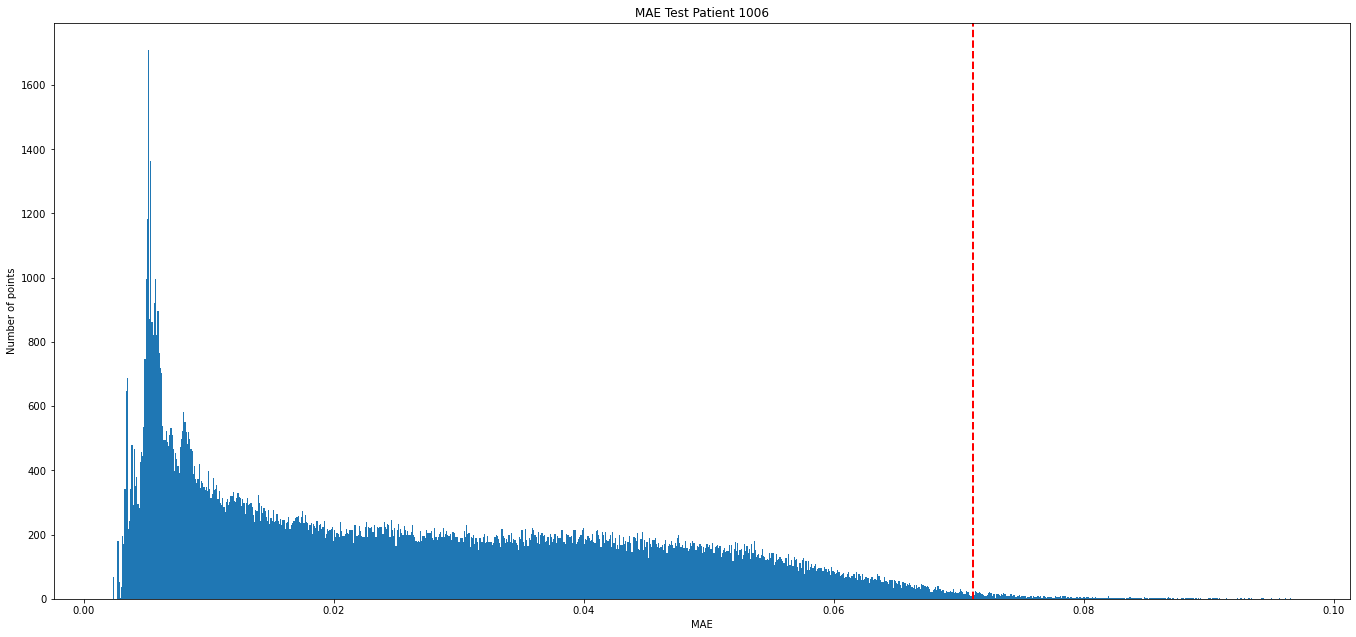

In [29]:
fig = plt.figure()
ax = fig.add_axes([1,10,3,2])

plt.hist(test_mae_loss_1, bins =1000)
plt.axvline(ref_value_0 , color='r', linestyle='dashed', linewidth=2)
plt.title('MAE Test Patient 1006')
plt.xlabel('MAE')
plt.ylabel('Number of points')

Text(0, 0.5, 'Number of points')

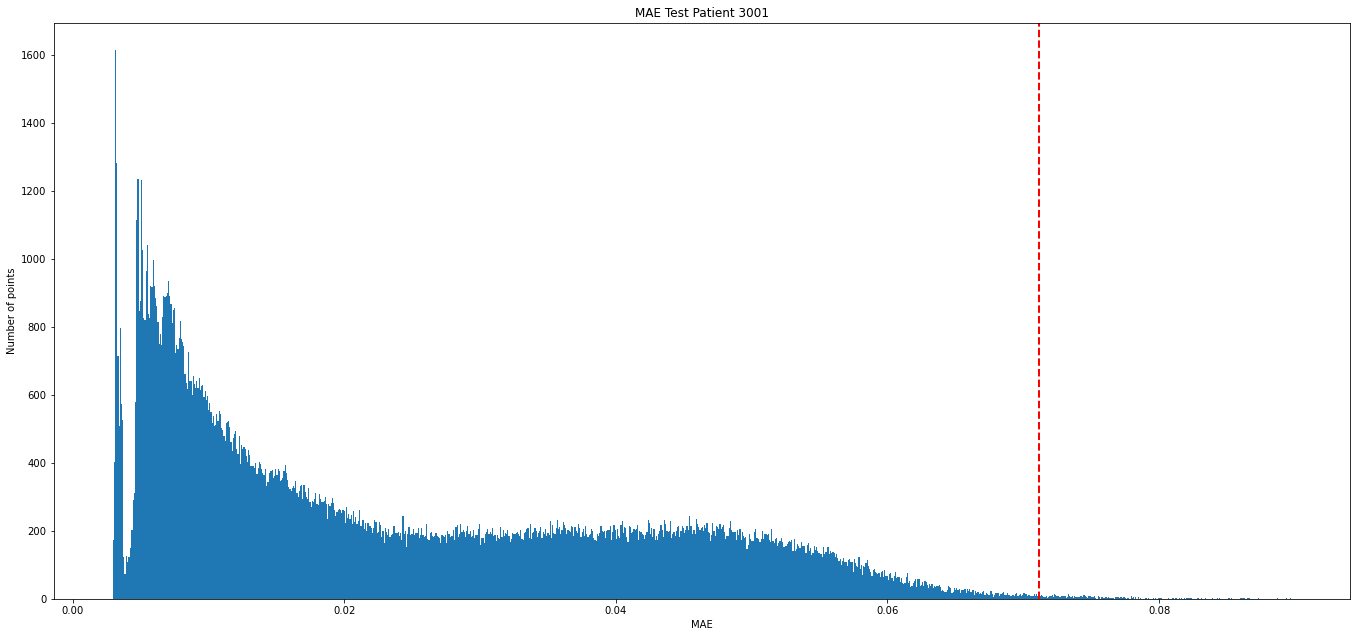

In [30]:
fig = plt.figure()
ax = fig.add_axes([1,10,3,2])

plt.hist(test_mae_loss_2, bins =1000)
plt.axvline(ref_value_0 , color='r', linestyle='dashed', linewidth=2)
plt.title('MAE Test Patient 3001')
plt.xlabel('MAE')
plt.ylabel('Number of points')

Text(0, 0.5, 'Number of points')

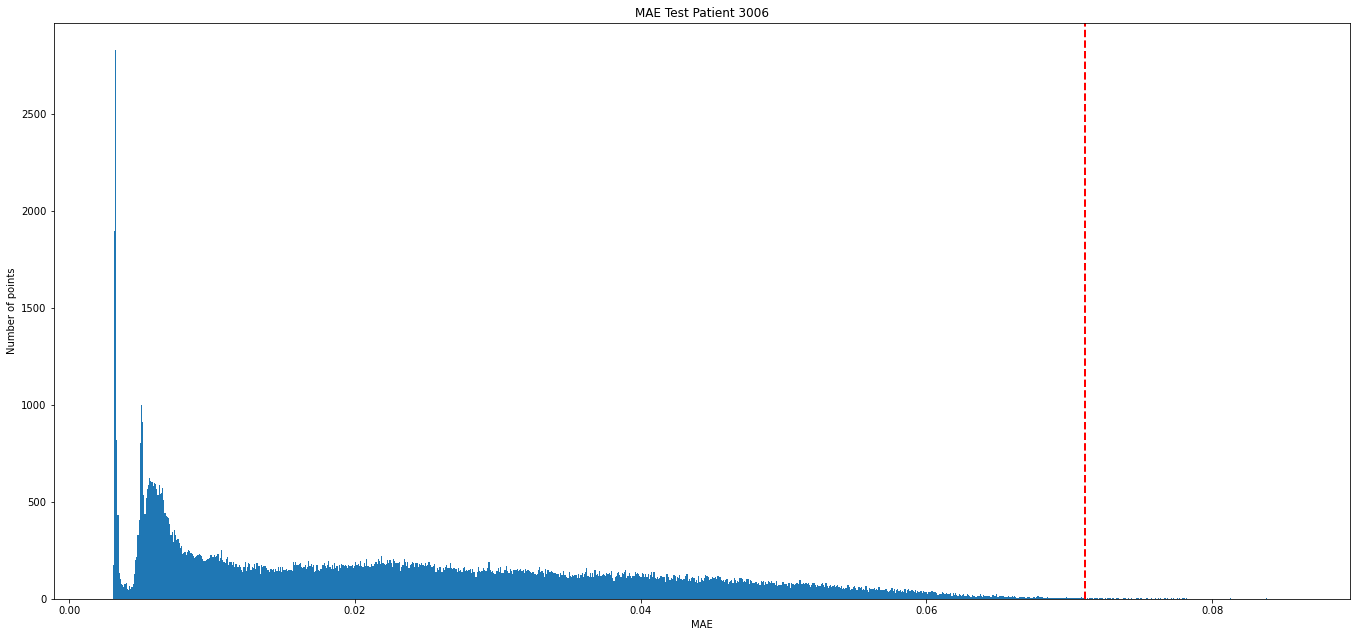

In [31]:
fig = plt.figure()
ax = fig.add_axes([1,10,3,2])

plt.hist(test_mae_loss_3, bins =1000)
plt.axvline(ref_value_0 , color='r', linestyle='dashed', linewidth=2)
plt.title('MAE Test Patient 3006')
plt.xlabel('MAE')
plt.ylabel('Number of points')

Text(0, 0.5, 'Number of points')

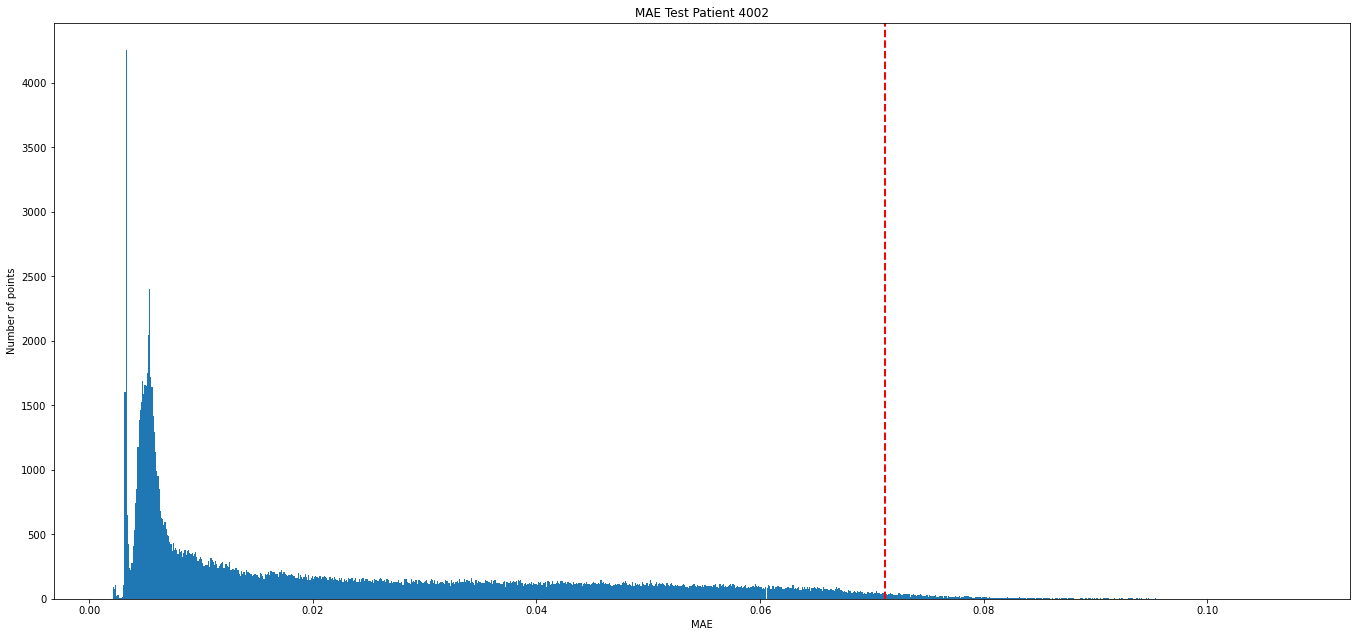

In [32]:
fig = plt.figure()
ax = fig.add_axes([1,10,3,2])

plt.hist(test_mae_loss_4, bins =1000)
plt.axvline(ref_value_0 , color='r', linestyle='dashed', linewidth=2)
plt.title('MAE Test Patient 4002')
plt.xlabel('MAE')
plt.ylabel('Number of points')

In [67]:
# Definiamo i treshold come ref_value_0
# Anche se in tale contesto i valori sono tutti analoghi, sono state comunque definite 5 varibili
# E' stato fatto ciò per non perdere di generalità e poter scegliere 5 threshold indipendenti tra loro
threshold_0=np.zeros(4)


threshold_0 =ref_value_0
threshold_1=threshold_0
threshold_2=threshold_0
threshold_3=threshold_0
threshold_4=threshold_0


print("Reconstruction error threshold of the patient 0: ", threshold_0)
print("Reconstruction error threshold of the patient 1: ", threshold_1)
print("Reconstruction error threshold of the patient 2: ", threshold_2)
print("Reconstruction error threshold of the patient 3: ", threshold_3)
print("Reconstruction error threshold of the patient 4: ", threshold_4)

Reconstruction error threshold of the patient 0:  0.07112893870123783
Reconstruction error threshold of the patient 1:  0.07112893870123783
Reconstruction error threshold of the patient 2:  0.07112893870123783
Reconstruction error threshold of the patient 3:  0.07112893870123783
Reconstruction error threshold of the patient 4:  0.07112893870123783


In [68]:
#Poniamo True tutti gli indici che presentano una MAE superiore a quella di threshold
anomalies_0 = test_mae_loss_0 > threshold_0
anomalies_1 = test_mae_loss_1 > threshold_1
anomalies_2 = test_mae_loss_2 > threshold_2
anomalies_3 = test_mae_loss_3 > threshold_3
anomalies_4 = test_mae_loss_4 > threshold_4
print("Number of anomaly of the patient 0: ", np.sum(anomalies_0))
print("Number of anomaly of the patient 1: ", np.sum(anomalies_1))
print("Number of anomaly of the patient 2: ", np.sum(anomalies_2))
print("Number of anomaly of the patient 3: ", np.sum(anomalies_3))
print("Number of anomaly of the patient 4: ", np.sum(anomalies_4))

Number of anomaly of the patient 0:  556
Number of anomaly of the patient 1:  1069
Number of anomaly of the patient 2:  492
Number of anomaly of the patient 3:  175
Number of anomaly of the patient 4:  2639


In [69]:
# Definiamo delle liste contenenti le anomalie
anomalous_data_indices_0 = []
anomalous_data_indices_1 = []
anomalous_data_indices_2 = []
anomalous_data_indices_3 = []
anomalous_data_indices_4 = []

#Salviamo gli indici associati alle anomalie

for data in range (0, len(test_mae_loss_0)-1):
  if(anomalies_0[data]==True ):
    anomalous_data_indices_0.append(data)
    
for data in range (0, len(test_mae_loss_1)-1):
  if(anomalies_1[data]==True):
    anomalous_data_indices_1.append(data)
    
for data in range (0, len(test_mae_loss_2)-1):
  if(anomalies_2[data]==True):
    anomalous_data_indices_2.append(data)
    
for data in range (0, len(test_mae_loss_3)-1):
  if(anomalies_3[data]==True):
    anomalous_data_indices_3.append(data)
    
for data in range (0, len(test_mae_loss_4)-1):
  if(anomalies_4[data]==True):
    anomalous_data_indices_4.append(data)
    
print('Dimensione  ',len(anomalous_data_indices_0))
print('Dimensione  ',len(anomalous_data_indices_1))
print('Dimensione  ',len(anomalous_data_indices_2))
print('Dimensione  ',len(anomalous_data_indices_3))
print('Dimensione  ',len(anomalous_data_indices_4))

Dimensione   556
Dimensione   1069
Dimensione   492
Dimensione   175
Dimensione   2639


In [70]:
# Definiamo dei DataFrame per associare le anomalie ai valori del dataset
anomalies_0 =  test_x_0.iloc[anomalous_data_indices_0]
anomalies_1 =  test_x_1.iloc[anomalous_data_indices_1]
anomalies_2 =  test_x_2.iloc[anomalous_data_indices_2]
anomalies_3 =  test_x_3.iloc[anomalous_data_indices_3]
anomalies_4 =  test_x_4.iloc[anomalous_data_indices_4]

Text(0, 0.5, 'heartRate values')

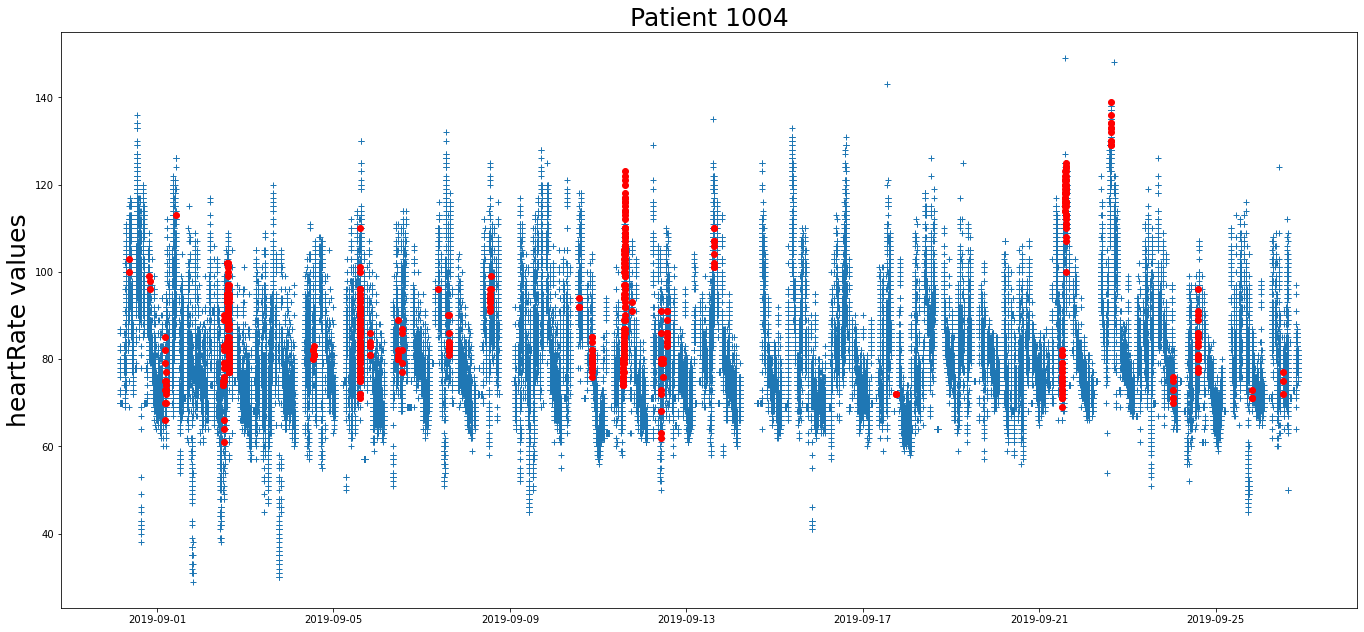

In [71]:
fig = plt.figure()

ax = fig.add_axes([1,10,3,2])
plt.plot(test_x_0['tsDate'].astype('datetime64[ns]') ,test_x_0['heartRate']*massimo_train_heartRate+minimo_train_heartRate  , '+')
plt.plot(anomalies_0['tsDate'].astype('datetime64[ns]') ,anomalies_0['heartRate']*massimo_train_heartRate+minimo_train_heartRate , 'o',color ='red')
plt.title('Patient 1004', fontsize=25)
plt.ylabel('heartRate values', fontsize=25)


Text(0, 0.5, 'x values')

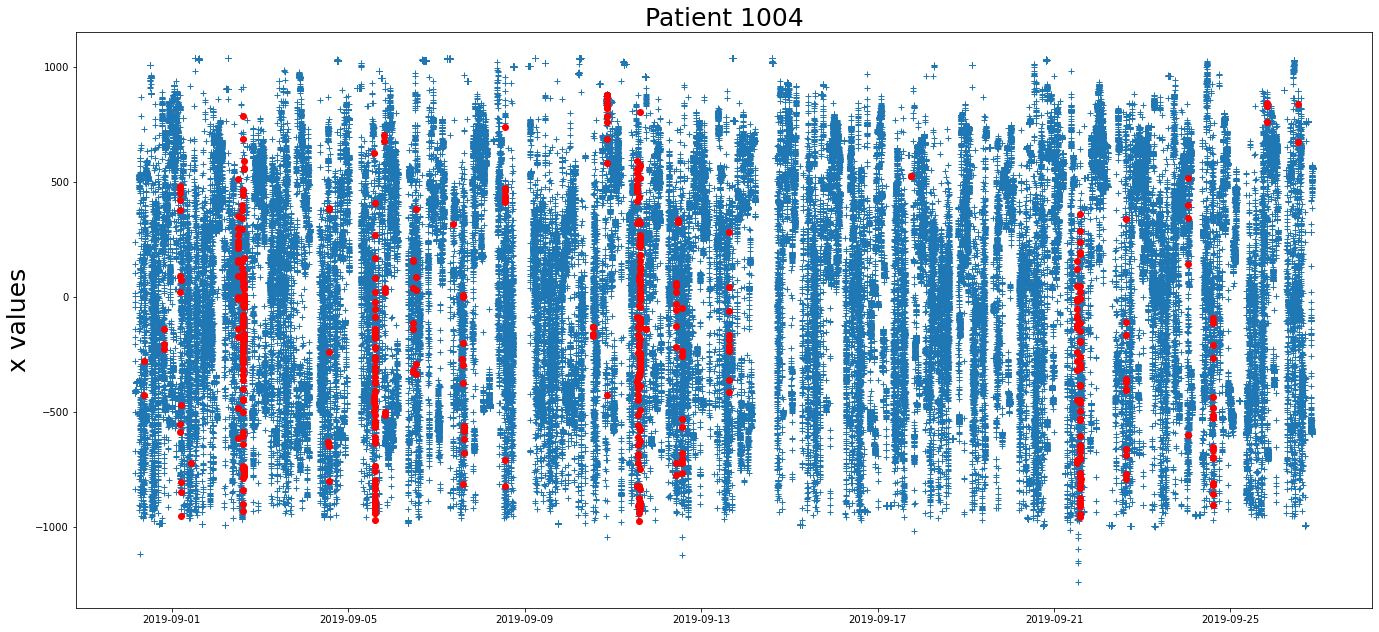

In [72]:
fig = plt.figure()

ax = fig.add_axes([1,10,3,2])
plt.plot(test_x_0['tsDate'].astype('datetime64[ns]') ,test_x_0['x'] *massimo_train_x+minimo_train_x , '+')
plt.plot(anomalies_0['tsDate'].astype('datetime64[ns]') ,anomalies_0['x']*massimo_train_x+minimo_train_x, 'o',color ='red')
plt.title('Patient 1004', fontsize=25)
plt.ylabel('x values', fontsize=25)

Text(0, 0.5, 'y values')

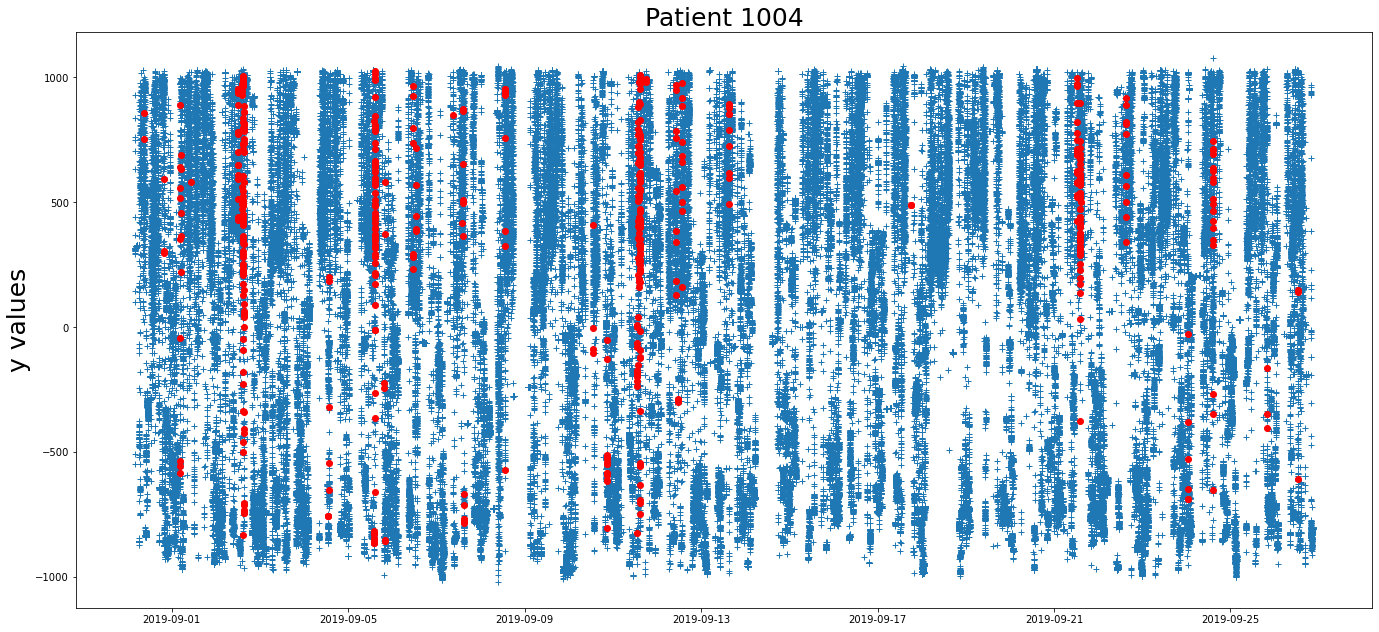

In [73]:
fig = plt.figure()

ax = fig.add_axes([1,10,3,2])
plt.plot(test_x_0['tsDate'].astype('datetime64[ns]') ,test_x_0['y']*massimo_train_y+minimo_train_y , '+')
plt.plot(anomalies_0['tsDate'].astype('datetime64[ns]') ,anomalies_0['y']*massimo_train_y+minimo_train_y, 'o',color ='red')
plt.title('Patient 1004', fontsize=25)
plt.ylabel('y values', fontsize=25)

Text(0, 0.5, 'z values')

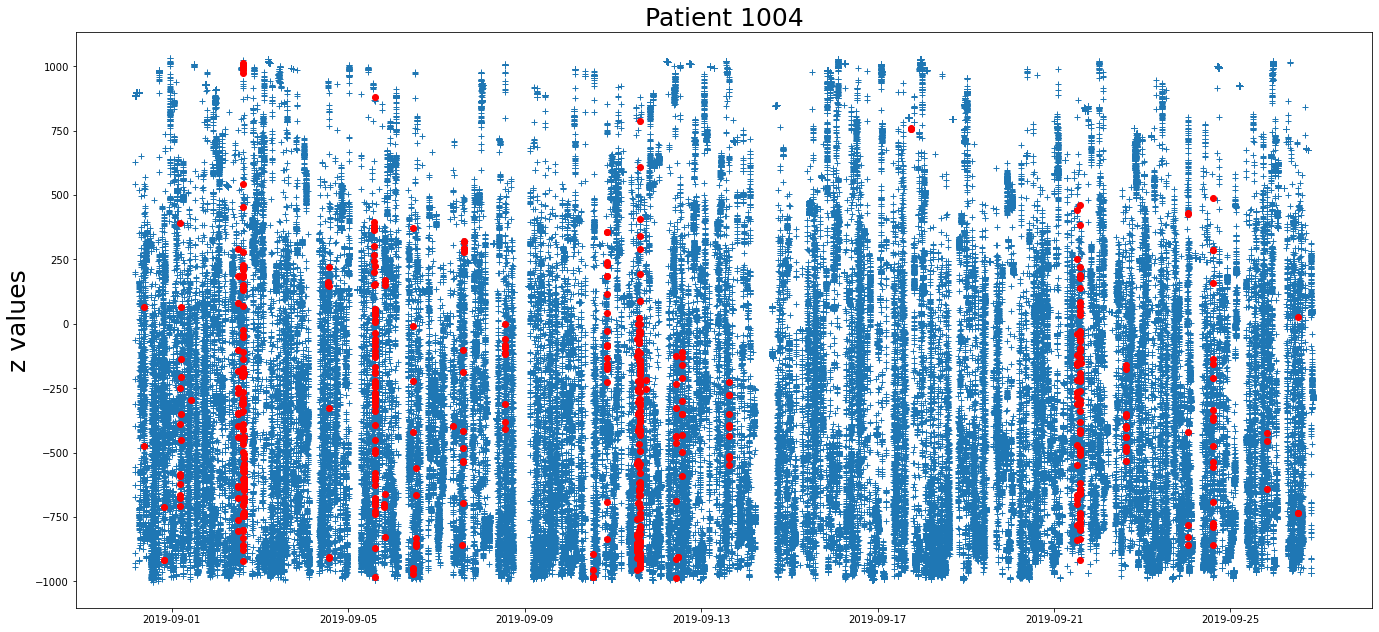

In [74]:
fig = plt.figure()

ax = fig.add_axes([1,10,3,2])
plt.plot(test_x_0['tsDate'].astype('datetime64[ns]') ,test_x_0['z']*massimo_train_z+minimo_train_z , '+')
plt.plot(anomalies_0['tsDate'].astype('datetime64[ns]') ,anomalies_0['z']*massimo_train_z+minimo_train_z, 'o',color ='red')
plt.title('Patient 1004', fontsize=25)
plt.ylabel('z values', fontsize=25)

Text(0, 0.5, 'heartRate values')

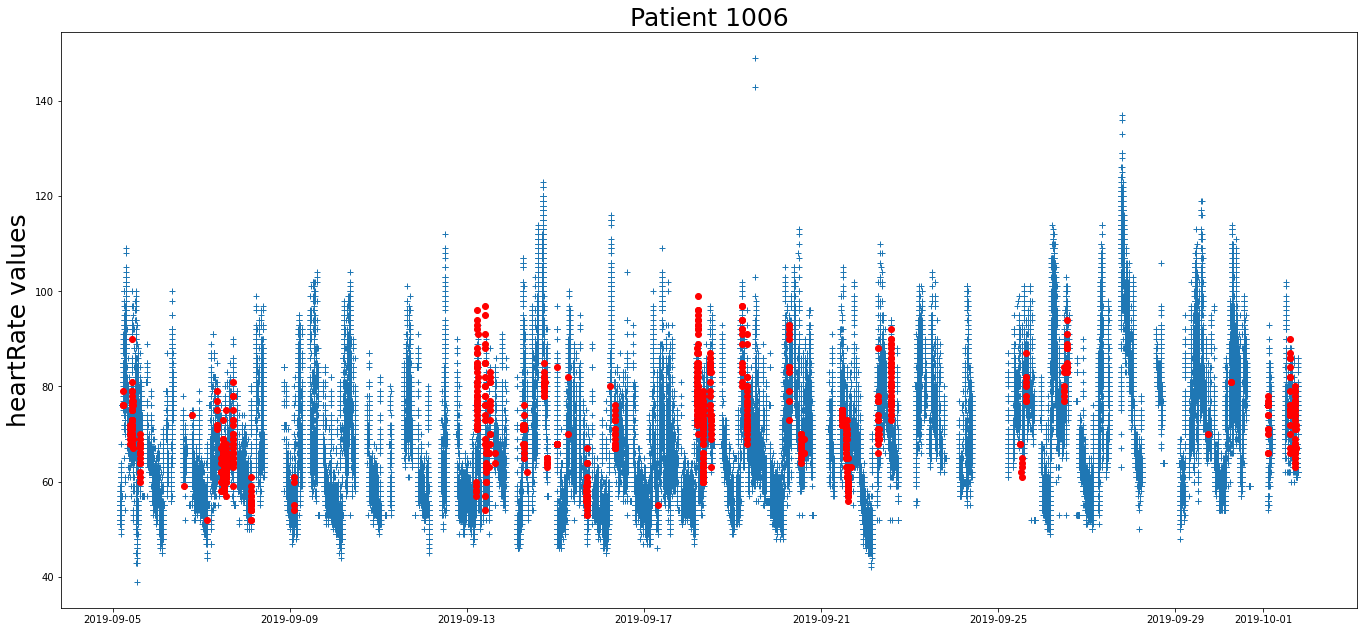

In [75]:
fig = plt.figure()

ax = fig.add_axes([1,10,3,2])
plt.plot(test_x_1['tsDate'].astype('datetime64[ns]') ,test_x_1['heartRate']*massimo_train_heartRate+minimo_train_heartRate   , '+')
plt.plot(anomalies_1['tsDate'].astype('datetime64[ns]') ,anomalies_1['heartRate']*massimo_train_heartRate+minimo_train_heartRate  , 'o',color ='red')
plt.title('Patient 1006', fontsize=25)
plt.ylabel('heartRate values', fontsize=25)

Text(0, 0.5, 'x values')

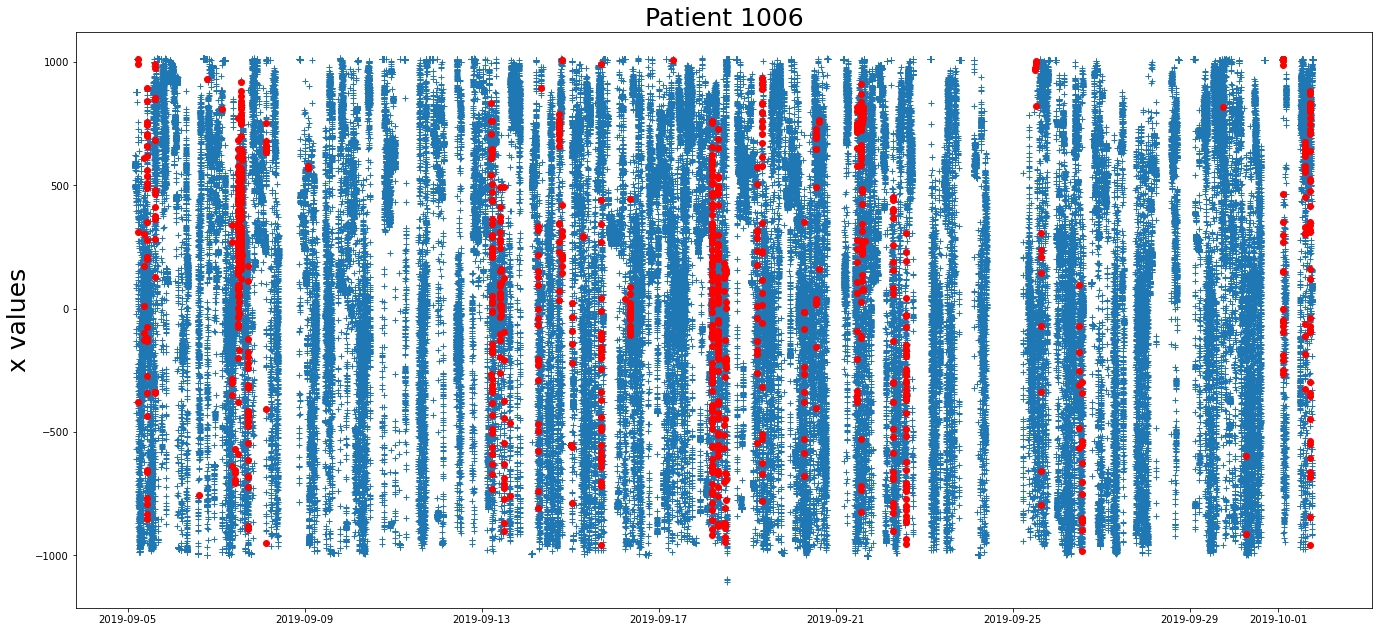

In [76]:
fig = plt.figure()

ax = fig.add_axes([1,10,3,2])
plt.plot(test_x_1['tsDate'].astype('datetime64[ns]') ,test_x_1['x']*massimo_train_x+minimo_train_x , '+')
plt.plot(anomalies_1['tsDate'].astype('datetime64[ns]') ,anomalies_1['x']*massimo_train_x+minimo_train_x, 'o',color ='red')
plt.title('Patient 1006', fontsize=25)
plt.ylabel('x values', fontsize=25)

Text(0, 0.5, 'y values')

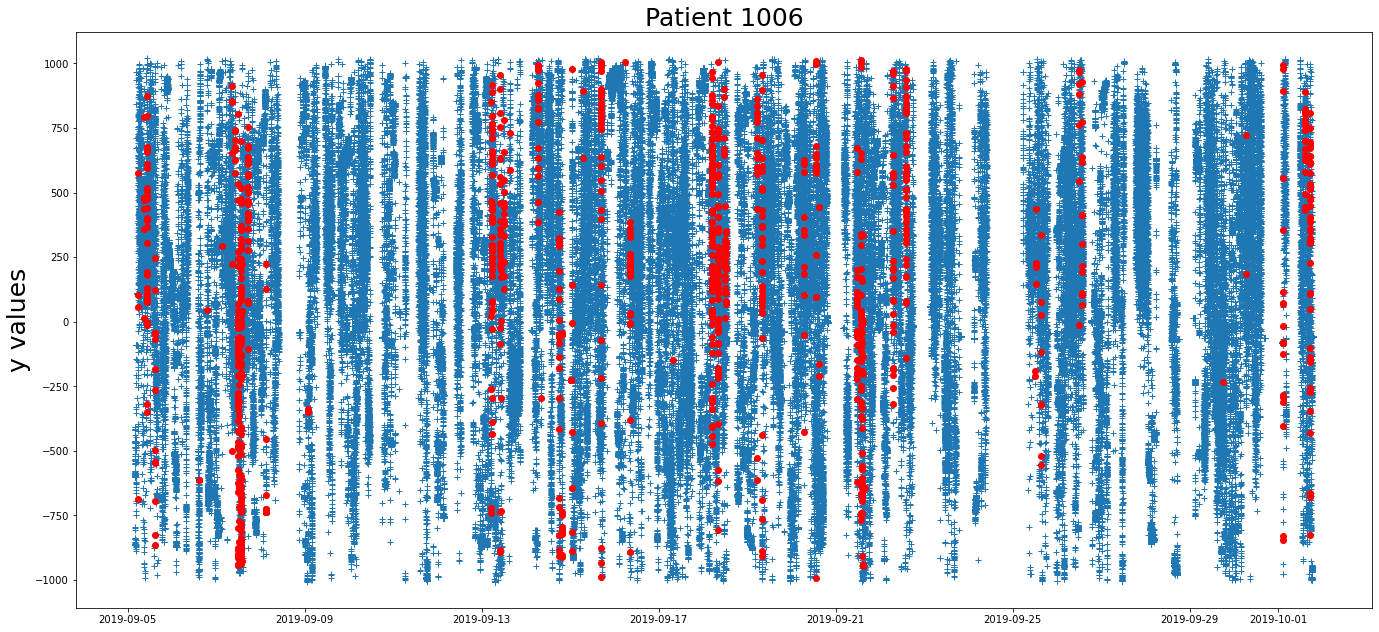

In [77]:
fig = plt.figure()

ax = fig.add_axes([1,10,3,2])
plt.plot(test_x_1['tsDate'].astype('datetime64[ns]') ,test_x_1['y']*massimo_train_y+minimo_train_y , '+')
plt.plot(anomalies_1['tsDate'].astype('datetime64[ns]') ,anomalies_1['y']*massimo_train_y+minimo_train_y, 'o',color ='red')
plt.title('Patient 1006', fontsize=25)
plt.ylabel('y values', fontsize=25)

Text(0, 0.5, 'z values')

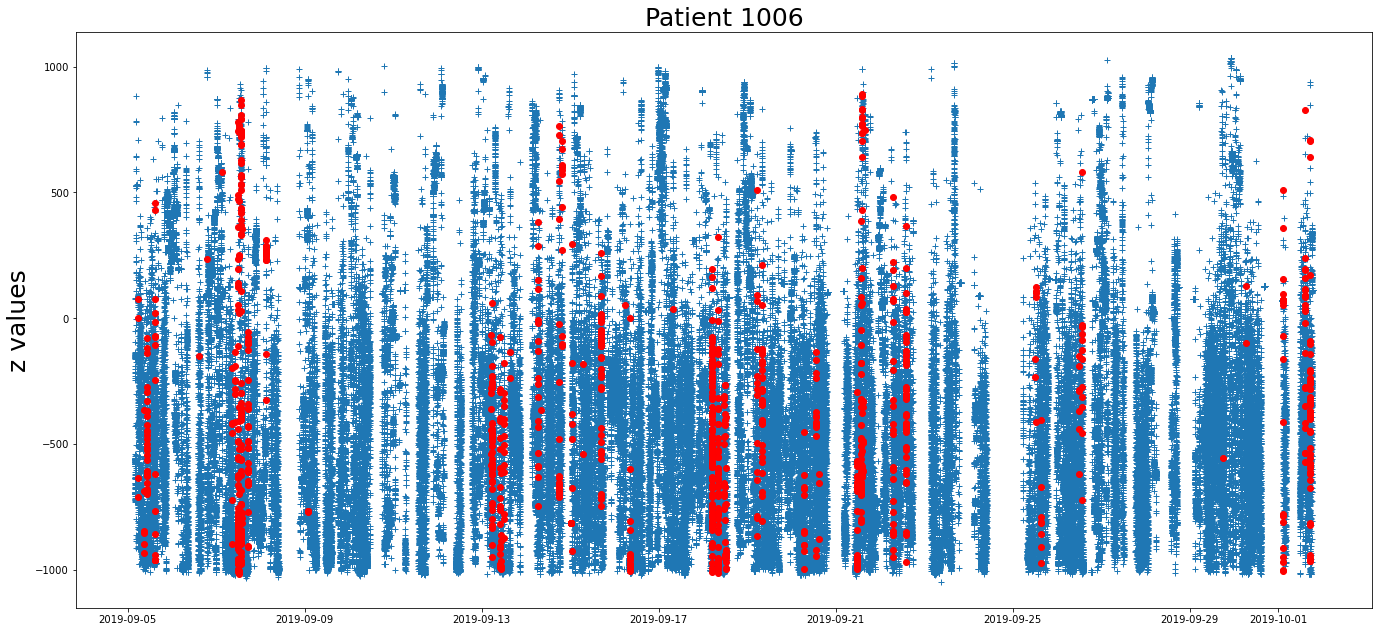

In [78]:
fig = plt.figure()

ax = fig.add_axes([1,10,3,2])
plt.plot(test_x_1['tsDate'].astype('datetime64[ns]') ,test_x_1['z']*massimo_train_z+minimo_train_z , '+')
plt.plot(anomalies_1['tsDate'].astype('datetime64[ns]') ,anomalies_1['z']*massimo_train_z+minimo_train_z, 'o',color ='red')
plt.title('Patient 1006', fontsize=25)
plt.ylabel('z values', fontsize=25)

Text(0, 0.5, 'heartRate values')

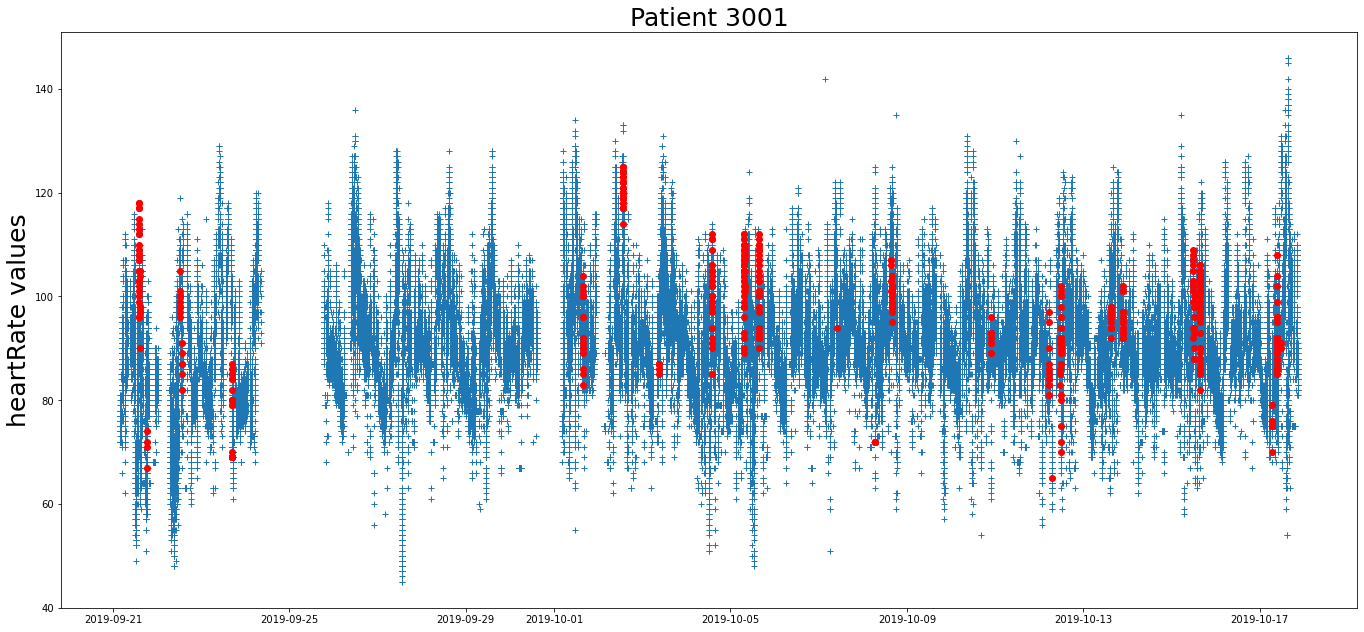

In [79]:
fig = plt.figure()

ax = fig.add_axes([1,10,3,2])
plt.plot(test_x_2['tsDate'].astype('datetime64[ns]') ,test_x_2['heartRate']*massimo_train_heartRate+minimo_train_heartRate   , '+')
plt.plot(anomalies_2['tsDate'].astype('datetime64[ns]') ,anomalies_2['heartRate']*massimo_train_heartRate+minimo_train_heartRate  , 'o',color ='red')
plt.title('Patient 3001', fontsize=25)
plt.ylabel('heartRate values', fontsize=25)

Text(0, 0.5, 'x values')

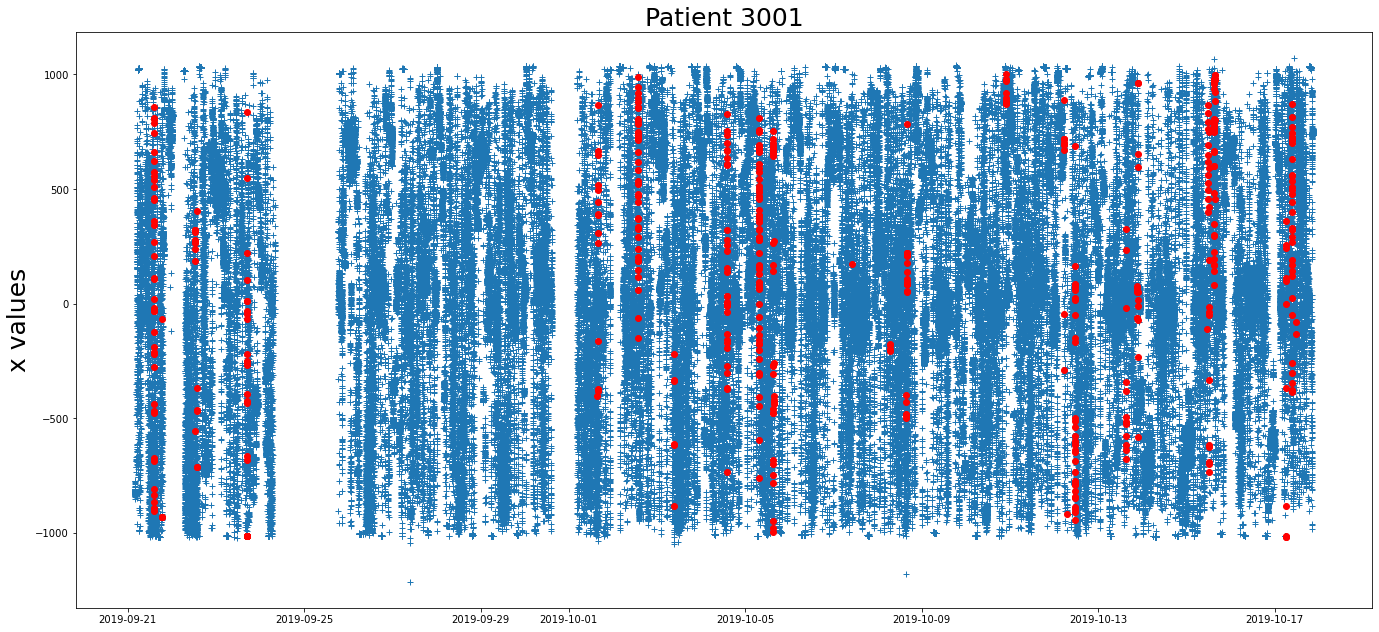

In [80]:
fig = plt.figure()

ax = fig.add_axes([1,10,3,2])
plt.plot(test_x_2['tsDate'].astype('datetime64[ns]') ,test_x_2['x']*massimo_train_x+minimo_train_x , '+')
plt.plot(anomalies_2['tsDate'].astype('datetime64[ns]') ,anomalies_2['x']*massimo_train_x+minimo_train_x, 'o',color ='red')
plt.title('Patient 3001', fontsize=25)
plt.ylabel('x values', fontsize=25)

Text(0, 0.5, 'y values')

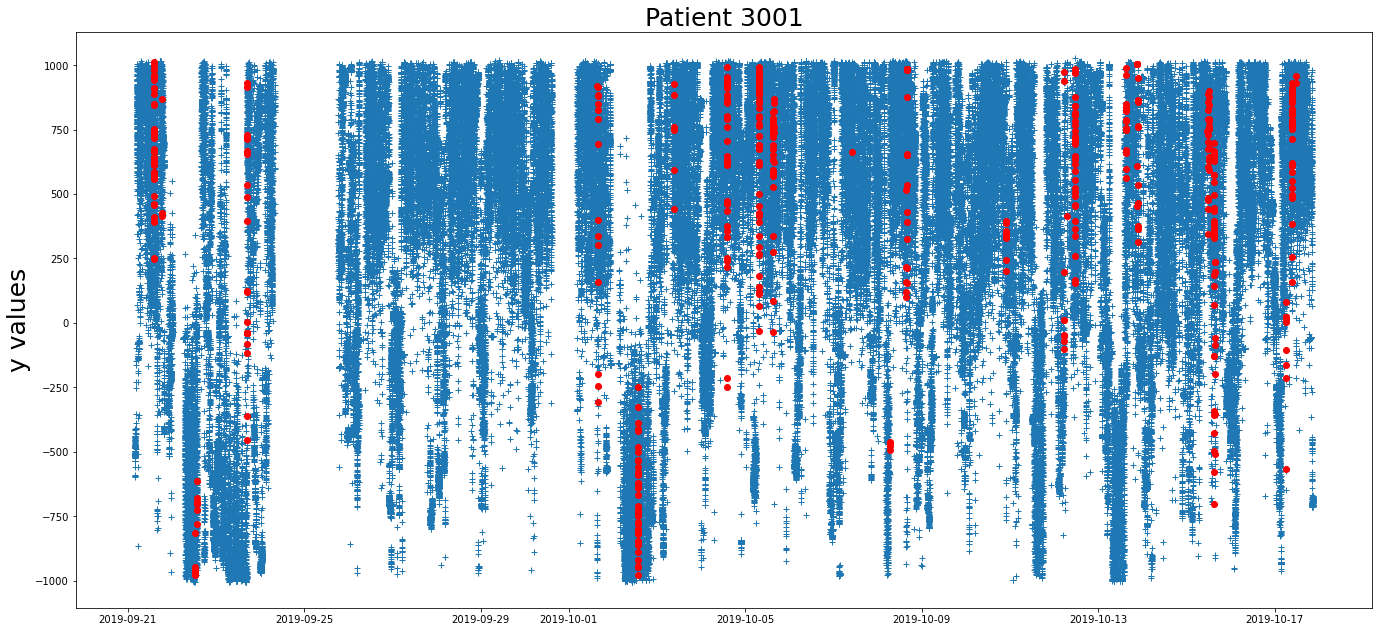

In [81]:
fig = plt.figure()

ax = fig.add_axes([1,10,3,2])
plt.plot(test_x_2['tsDate'].astype('datetime64[ns]') ,test_x_2['y']*massimo_train_y+minimo_train_y , '+')
plt.plot(anomalies_2['tsDate'].astype('datetime64[ns]') ,anomalies_2['y']*massimo_train_y+minimo_train_y, 'o',color ='red')
plt.title('Patient 3001', fontsize=25)
plt.ylabel('y values', fontsize=25)

Text(0, 0.5, 'z values')

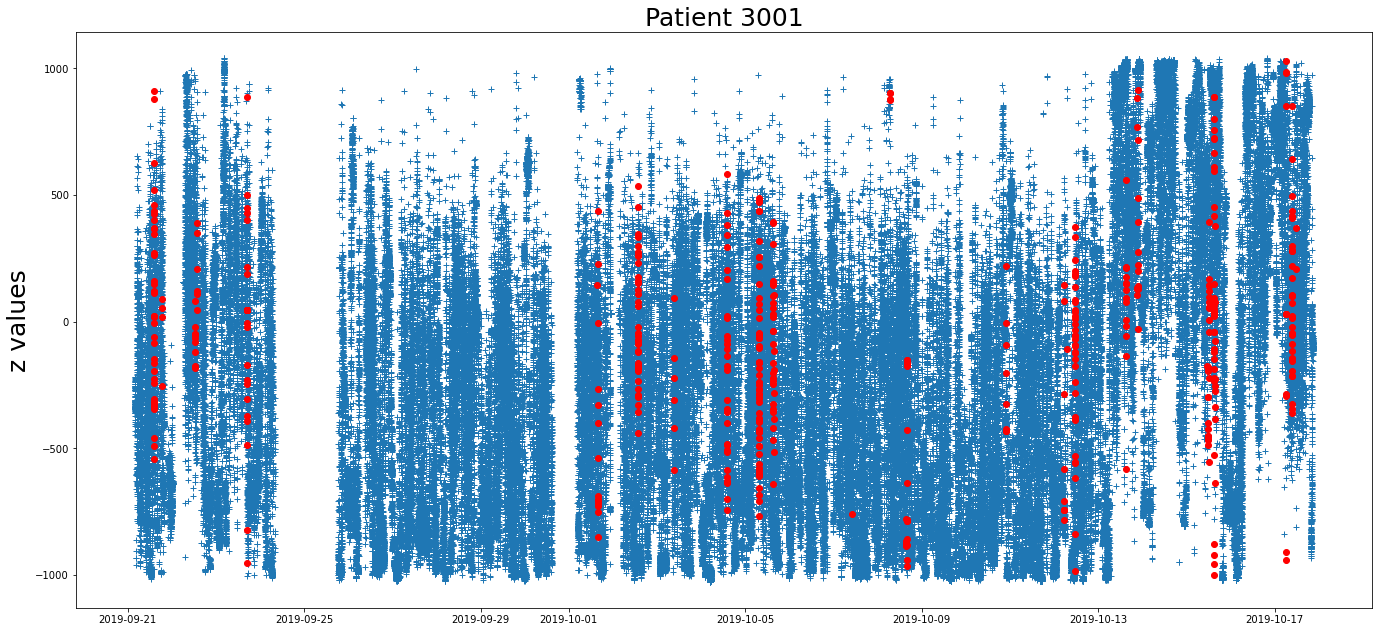

In [82]:
fig = plt.figure()

ax = fig.add_axes([1,10,3,2])
plt.plot(test_x_2['tsDate'].astype('datetime64[ns]') ,test_x_2['z']*massimo_train_z+minimo_train_z , '+')
plt.plot(anomalies_2['tsDate'].astype('datetime64[ns]') ,anomalies_2['z']*massimo_train_z+minimo_train_z, 'o',color ='red')
plt.title('Patient 3001', fontsize=25)
plt.ylabel('z values', fontsize=25)

Text(0, 0.5, 'heartRate values')

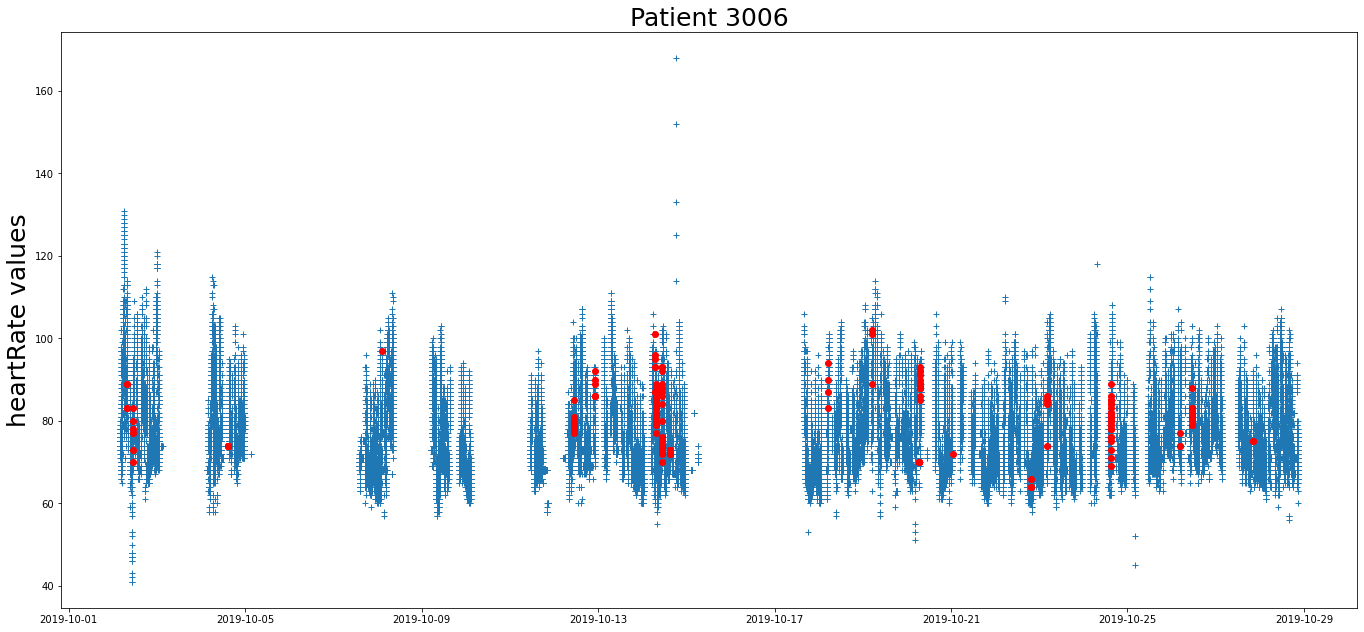

In [83]:
fig = plt.figure()

ax = fig.add_axes([1,10,3,2])
plt.plot(test_x_3['tsDate'].astype('datetime64[ns]') ,test_x_3['heartRate']*massimo_train_heartRate+minimo_train_heartRate   , '+')
plt.plot(anomalies_3['tsDate'].astype('datetime64[ns]') ,anomalies_3['heartRate']*massimo_train_heartRate+minimo_train_heartRate  , 'o',color ='red')
plt.title('Patient 3006', fontsize=25)
plt.ylabel('heartRate values', fontsize=25)

Text(0, 0.5, 'x values')

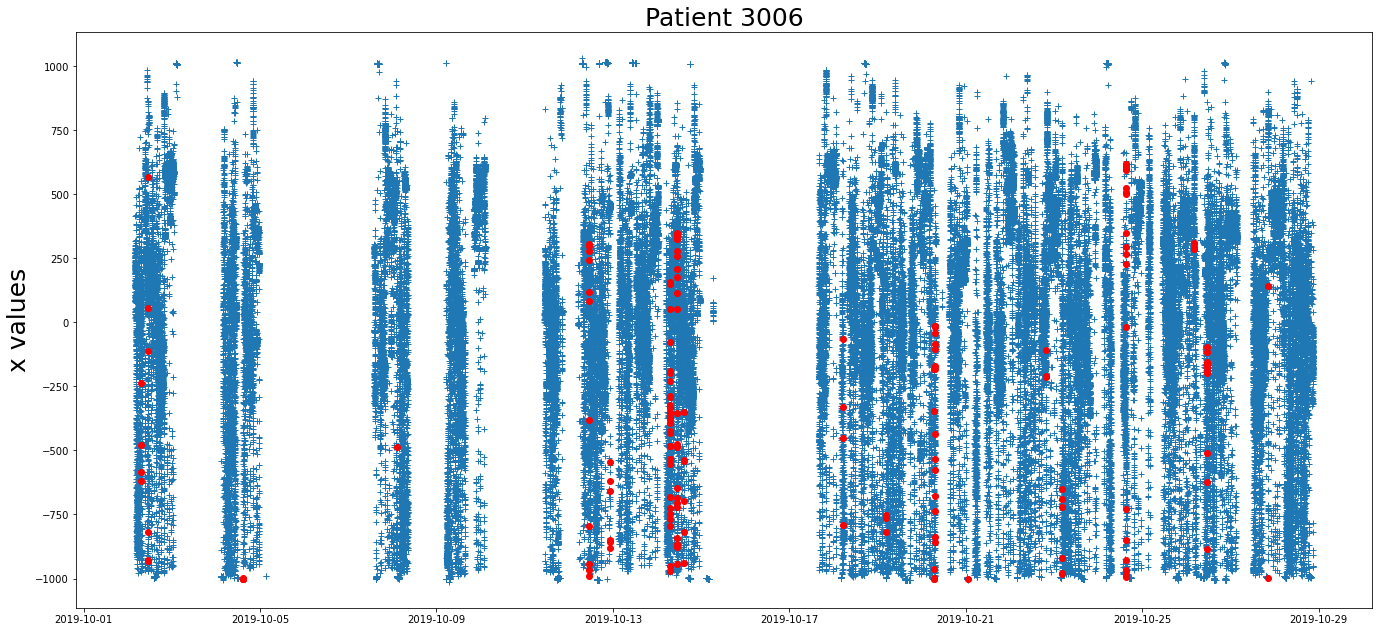

In [84]:
fig = plt.figure()

ax = fig.add_axes([1,10,3,2])
plt.plot(test_x_3['tsDate'].astype('datetime64[ns]') ,test_x_3['x']*massimo_train_x+minimo_train_x , '+')
plt.plot(anomalies_3['tsDate'].astype('datetime64[ns]') ,anomalies_3['x']*massimo_train_x+minimo_train_x, 'o',color ='red')
plt.title('Patient 3006', fontsize=25)
plt.ylabel('x values', fontsize=25)

Text(0, 0.5, 'y values')

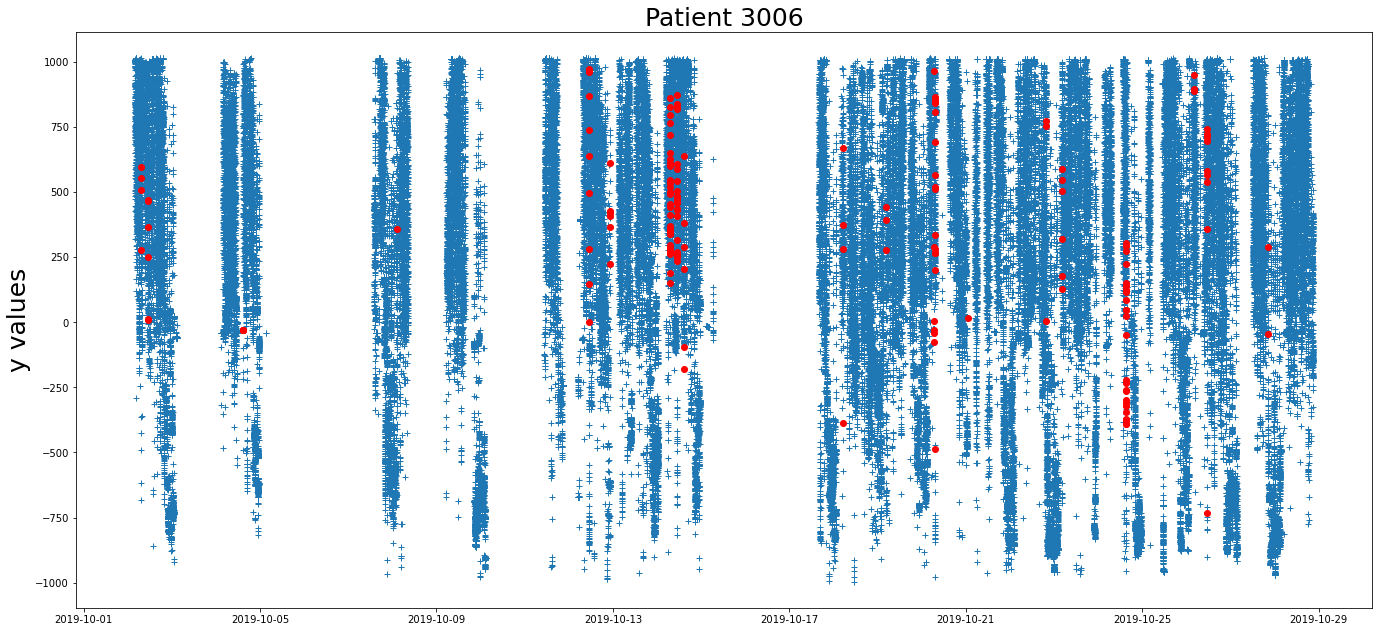

In [85]:
fig = plt.figure()

ax = fig.add_axes([1,10,3,2])
plt.plot(test_x_3['tsDate'].astype('datetime64[ns]') ,test_x_3['y']*massimo_train_y+minimo_train_y , '+')
plt.plot(anomalies_3['tsDate'].astype('datetime64[ns]') ,anomalies_3['y']*massimo_train_y+minimo_train_y, 'o',color ='red')
plt.title('Patient 3006', fontsize=25)
plt.ylabel('y values', fontsize=25)

Text(0, 0.5, 'z values')

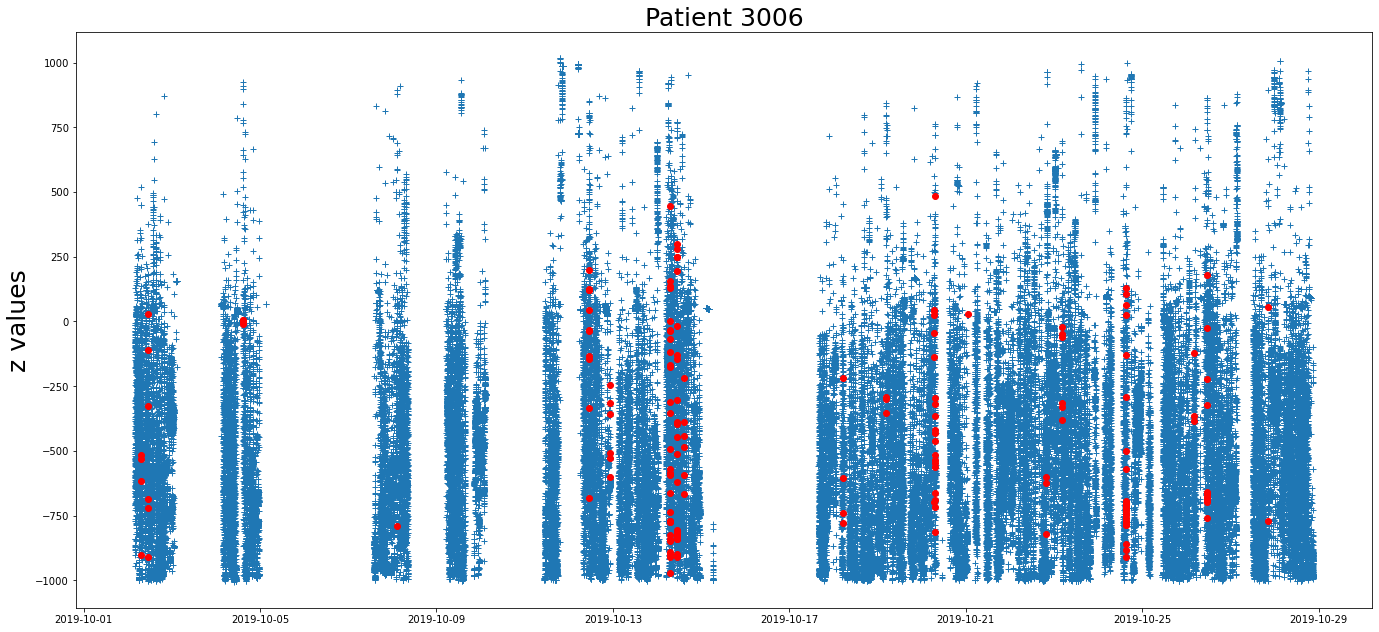

In [86]:
fig = plt.figure()

ax = fig.add_axes([1,10,3,2])
plt.plot(test_x_3['tsDate'].astype('datetime64[ns]') ,test_x_3['z']*massimo_train_z+minimo_train_z , '+')
plt.plot(anomalies_3['tsDate'].astype('datetime64[ns]') ,anomalies_3['z']*massimo_train_z+minimo_train_z, 'o',color ='red')
plt.title('Patient 3006', fontsize=25)
plt.ylabel('z values', fontsize=25)

Text(0, 0.5, 'heartRate values')

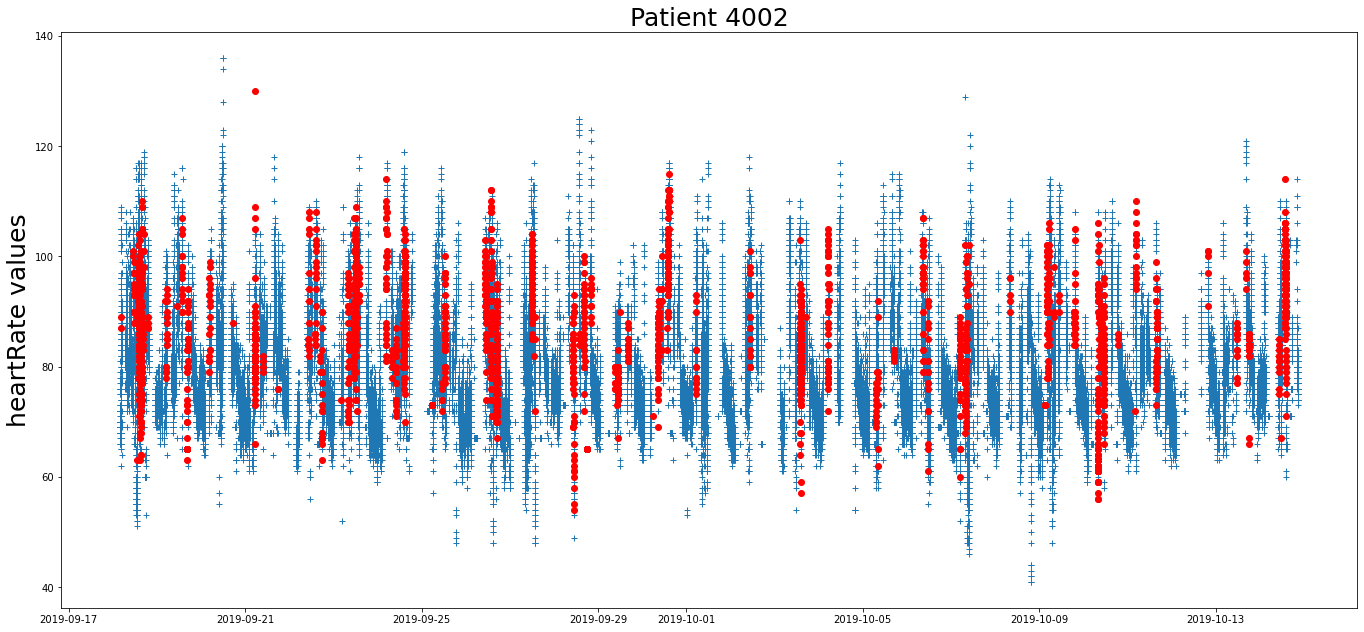

In [87]:
fig = plt.figure()

ax = fig.add_axes([1,10,3,2])
plt.plot(test_x_4['tsDate'].astype('datetime64[ns]') ,test_x_4['heartRate']*massimo_train_heartRate+minimo_train_heartRate   , '+')
plt.plot(anomalies_4['tsDate'].astype('datetime64[ns]') ,anomalies_4['heartRate']*massimo_train_heartRate+minimo_train_heartRate  , 'o',color ='red')
plt.title('Patient 4002', fontsize=25)
plt.ylabel('heartRate values', fontsize=25)

Text(0, 0.5, 'x values')

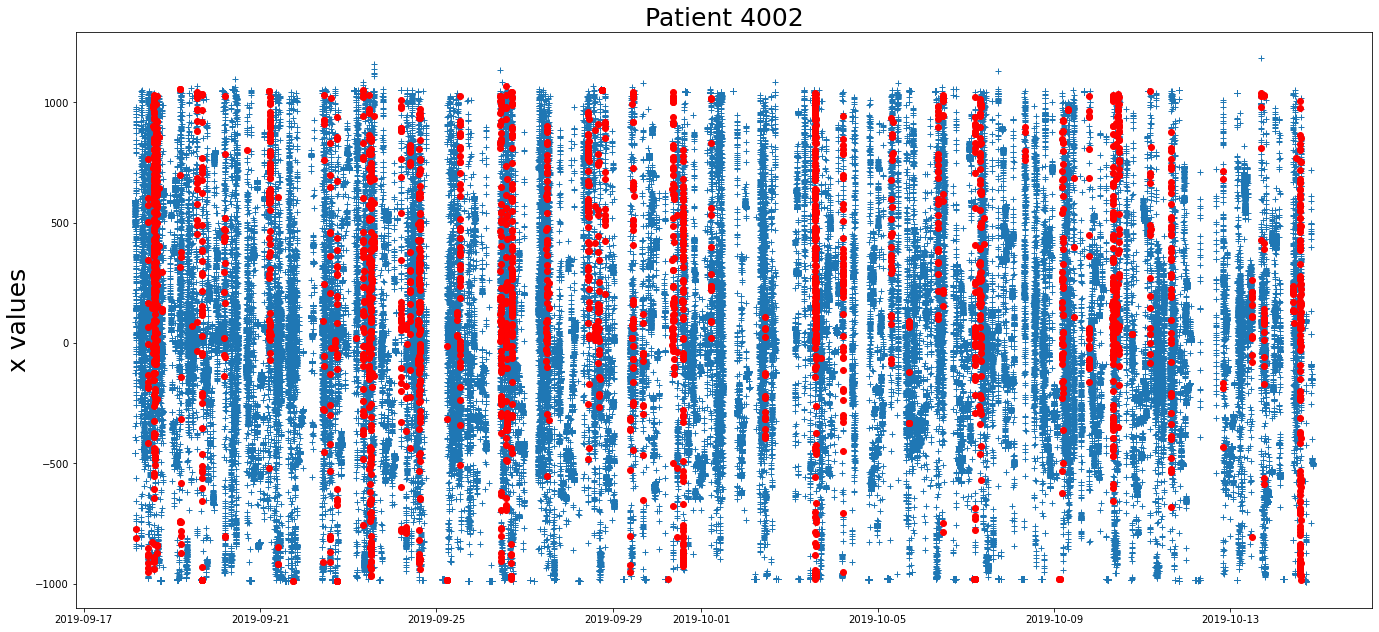

In [88]:
fig = plt.figure()

ax = fig.add_axes([1,10,3,2])
plt.plot(test_x_4['tsDate'].astype('datetime64[ns]') ,test_x_4['x']*massimo_train_x+minimo_train_x , '+')
plt.plot(anomalies_4['tsDate'].astype('datetime64[ns]') ,anomalies_4['x']*massimo_train_x+minimo_train_x, 'o',color ='red')
plt.title('Patient 4002', fontsize=25)
plt.ylabel('x values', fontsize=25)

Text(0, 0.5, 'y values')

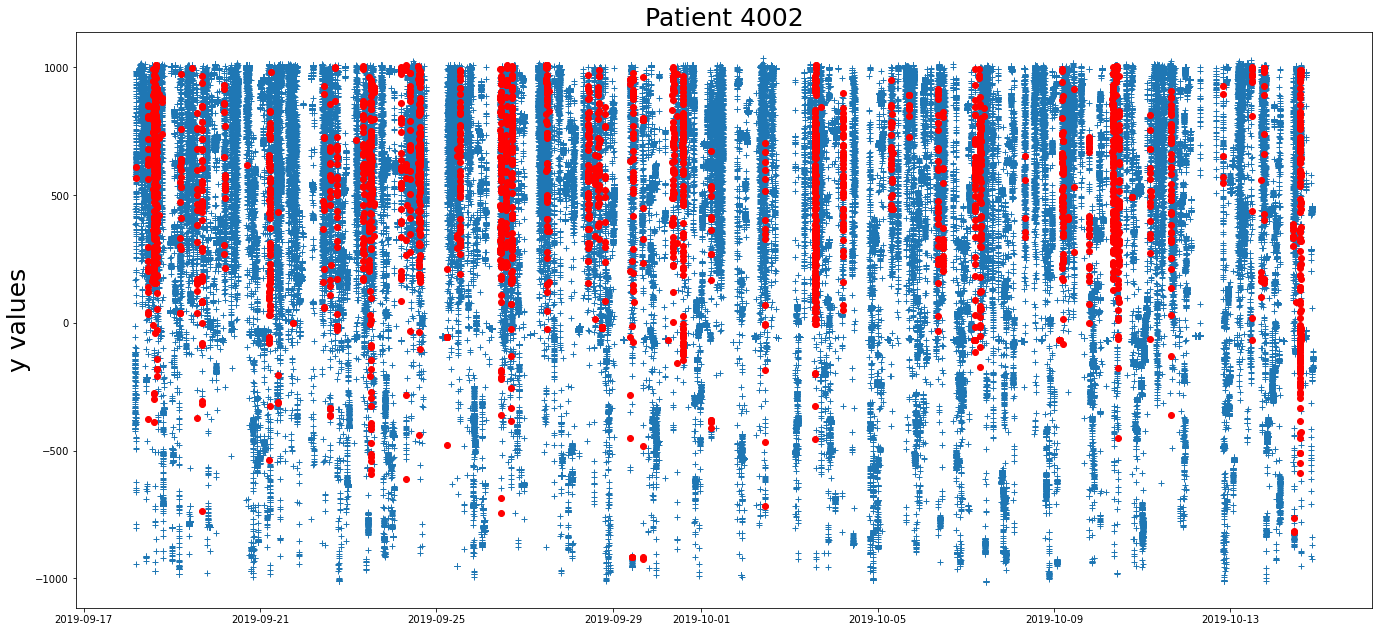

In [89]:
fig = plt.figure()

ax = fig.add_axes([1,10,3,2])
plt.plot(test_x_4['tsDate'].astype('datetime64[ns]') ,test_x_4['y']*massimo_train_y+minimo_train_y , '+')
plt.plot(anomalies_4['tsDate'].astype('datetime64[ns]') ,anomalies_4['y']*massimo_train_y+minimo_train_y, 'o',color ='red')
plt.title('Patient 4002', fontsize=25)
plt.ylabel('y values', fontsize=25)

Text(0, 0.5, 'z values')

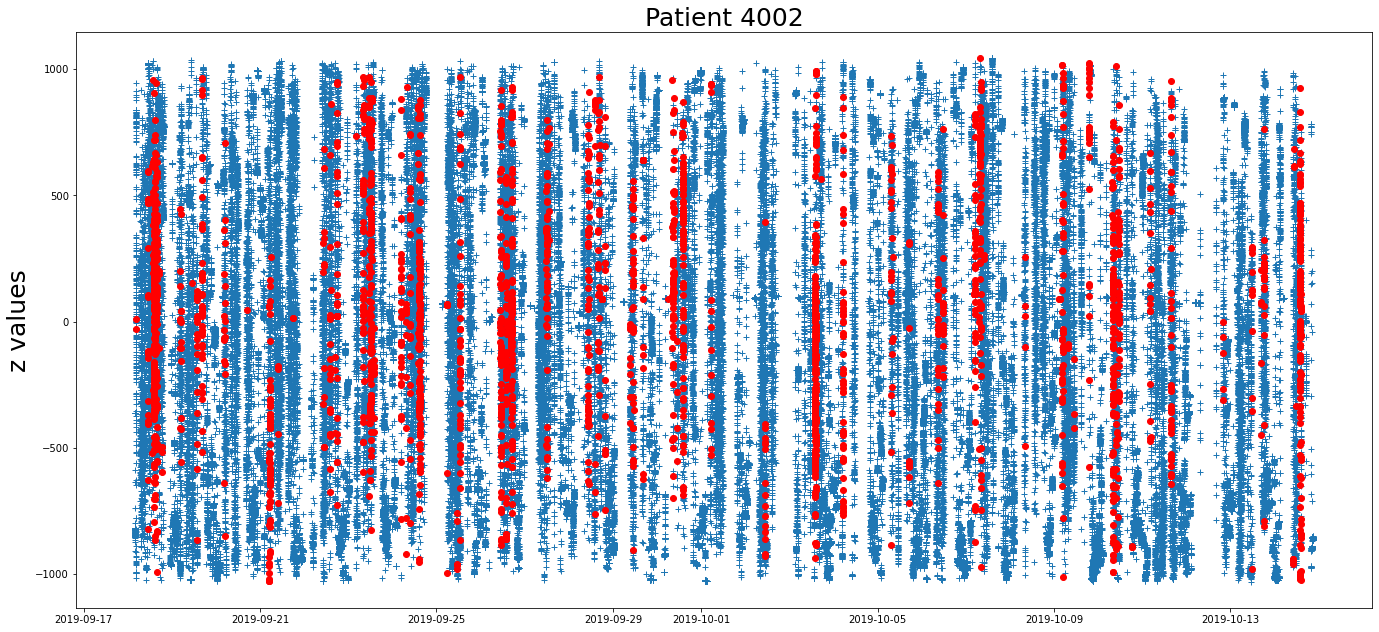

In [90]:
fig = plt.figure()

ax = fig.add_axes([1,10,3,2])
plt.plot(test_x_4['tsDate'].astype('datetime64[ns]') ,test_x_4['z']*massimo_train_z+minimo_train_z , '+')
plt.plot(anomalies_4['tsDate'].astype('datetime64[ns]') ,anomalies_4['z']*massimo_train_z+minimo_train_z, 'o',color ='red')
plt.title('Patient 4002', fontsize=25)
plt.ylabel('z values', fontsize=25)

In [91]:
#Riscaliamo e plottiamo le anomalie

In [92]:
anomalies_0['heartRate'] = anomalies_0['heartRate']*massimo_train_heartRate+minimo_train_heartRate 
anomalies_0['x'] = anomalies_0['x']*massimo_train_x+minimo_train_x 
anomalies_0['y'] = anomalies_0['y']*massimo_train_y+minimo_train_y 
anomalies_0['z'] = anomalies_0['z']*massimo_train_z+minimo_train_z 
print(anomalies_0.to_string())

        patient      x       y       z  heartRate      timestamp                   tsDate
903        1004 -427.0   858.0    67.0      100.0  1567241574000  2019-08-31 08:52:54.532
904        1004 -280.0   753.0  -475.0      103.0  1567241584000  2019-08-31 08:53:04.540
3969       1004 -140.0   592.0  -712.0       99.0  1567281310000  2019-08-31 19:55:10.202
3971       1004 -204.0   306.0  -919.0       96.0  1567281330000  2019-08-31 19:55:30.226
3972       1004 -227.0   296.0  -917.0       98.0  1567281340000  2019-08-31 19:55:40.238
6758       1004  471.0  -556.0  -584.0       66.0  1567312569000  2019-09-01 04:36:09.319
6759       1004  419.0  -586.0  -666.0       70.0  1567312579000  2019-09-01 04:36:19.333
6760       1004  481.0  -535.0  -709.0       82.0  1567312589000  2019-09-01 04:36:29.347
6761       1004  453.0   -45.0  -677.0       85.0  1567312599000  2019-09-01 04:36:39.362
6762       1004 -552.0   352.0  -590.0       75.0  1567312609000  2019-09-01 04:36:49.376
6763      

C:\Users\simon\AppData\Local\Temp/ipykernel_9048/1079962375.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_0['heartRate'] = anomalies_0['heartRate']*massimo_train_heartRate+minimo_train_heartRate
C:\Users\simon\AppData\Local\Temp/ipykernel_9048/1079962375.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_0['x'] = anomalies_0['x']*massimo_train_x+minimo_train_x
C:\Users\simon\AppData\Local\Temp/ipykernel_9048/1079962375.py:3: SettingWithCopyWarning: 
A value is trying to be set on 

In [93]:
anomalies_1['heartRate'] = anomalies_1['heartRate']*massimo_train_heartRate+minimo_train_heartRate 
anomalies_1['x'] = anomalies_1['x']*massimo_train_x+minimo_train_x 
anomalies_1['y'] = anomalies_1['y']*massimo_train_y+minimo_train_y 
anomalies_1['z'] = anomalies_1['z']*massimo_train_z+minimo_train_z 
anomalies_1.index = anomalies_1.index + location_test[0]
print(anomalies_1.to_string())

C:\Users\simon\AppData\Local\Temp/ipykernel_9048/3712131044.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_1['heartRate'] = anomalies_1['heartRate']*massimo_train_heartRate+minimo_train_heartRate
C:\Users\simon\AppData\Local\Temp/ipykernel_9048/3712131044.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_1['x'] = anomalies_1['x']*massimo_train_x+minimo_train_x
C:\Users\simon\AppData\Local\Temp/ipykernel_9048/3712131044.py:3: SettingWithCopyWarning: 
A value is trying to be set on 

        patient       x       y       z  heartRate      timestamp                   tsDate
145508     1006  1010.0   104.0    77.0       76.0  1567662012000  2019-09-05 05:40:12.624
145509     1006   993.0    56.0     1.0       76.0  1567662022000  2019-09-05 05:40:22.628
145510     1006   311.0  -686.0  -637.0       76.0  1567662032000  2019-09-05 05:40:32.633
145522     1006  -377.0   577.0  -710.0       79.0  1567662152000  2019-09-05 05:42:32.786
146711     1006   -99.0   472.0  -899.0       71.0  1567674150000  2019-09-05 09:02:30.257
146712     1006  -129.0   357.0  -936.0       70.0  1567674160000  2019-09-05 09:02:40.275
146713     1006   302.0    14.0  -847.0       70.0  1567674170000  2019-09-05 09:02:50.292
146714     1006    10.0   791.0  -364.0       68.0  1567674180000  2019-09-05 09:03:00.306
146715     1006   609.0   438.0  -689.0       72.0  1567674190000  2019-09-05 09:03:10.323
146716     1006   171.0   477.0  -854.0       69.0  1567674200000  2019-09-05 09:03:20.339

In [94]:
anomalies_2['heartRate'] = anomalies_2['heartRate']*massimo_train_heartRate+minimo_train_heartRate 
anomalies_2['x'] = anomalies_2['x']*massimo_train_x+minimo_train_x 
anomalies_2['y'] = anomalies_2['y']*massimo_train_y+minimo_train_y 
anomalies_2['z'] = anomalies_2['z']*massimo_train_z+minimo_train_z  
anomalies_2.index = anomalies_2.index + location_test[1]
print(anomalies_2.to_string())

C:\Users\simon\AppData\Local\Temp/ipykernel_9048/1181240044.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_2['heartRate'] = anomalies_2['heartRate']*massimo_train_heartRate+minimo_train_heartRate
C:\Users\simon\AppData\Local\Temp/ipykernel_9048/1181240044.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_2['x'] = anomalies_2['x']*massimo_train_x+minimo_train_x
C:\Users\simon\AppData\Local\Temp/ipykernel_9048/1181240044.py:3: SettingWithCopyWarning: 
A value is trying to be set on 

        patient       x       y       z  heartRate      timestamp                   tsDate
296178     3001   109.0  1012.0    22.0      107.0  1569074886000  2019-09-21 14:08:06.728
296179     3001   208.0   911.0  -345.0      108.0  1569074896000  2019-09-21 14:08:16.748
296180     3001  -190.0   849.0  -227.0      107.0  1569074906000  2019-09-21 14:08:26.768
296181     3001   112.0   980.0   264.0      105.0  1569074916000  2019-09-21 14:08:36.769
296182     3001    19.0   962.0   347.0      112.0  1569074926000  2019-09-21 14:08:46.771
296183     3001   -31.0   944.0   403.0      114.0  1569074936000  2019-09-21 14:08:56.772
296184     3001   -32.0   956.0   368.0      115.0  1569074946000  2019-09-21 14:09:06.773
296185     3001  -438.0   844.0   270.0      105.0  1569074956000  2019-09-21 14:09:16.793
296186     3001   -19.0   664.0   628.0      108.0  1569074966000  2019-09-21 14:09:26.813
296187     3001   661.0   575.0   520.0      113.0  1569074976000  2019-09-21 14:09:36.833

In [95]:
anomalies_3['heartRate'] = anomalies_3['heartRate']*massimo_train_heartRate+minimo_train_heartRate 
anomalies_3['x'] = anomalies_3['x']*massimo_train_x+minimo_train_x 
anomalies_3['y'] = anomalies_3['y']*massimo_train_y+minimo_train_y 
anomalies_3['z'] = anomalies_3['z']*massimo_train_z+minimo_train_z 
anomalies_3.index = anomalies_3.index + location_test[2]
print(anomalies_3.to_string())

        patient       x      y      z  heartRate      timestamp                   tsDate
483414     3006  -236.0  276.0 -901.0       89.0  1570001260000  2019-10-02 07:27:40.784
483415     3006  -584.0  506.0 -517.0       83.0  1570001270000  2019-10-02 07:27:50.787
483416     3006  -618.0  554.0 -533.0       83.0  1570001280000  2019-10-02 07:28:00.791
483418     3006  -477.0  597.0 -616.0       89.0  1570001300000  2019-10-02 07:28:20.797
484210     3006   567.0  469.0 -684.0       70.0  1570013691000  2019-10-02 10:54:51.323
484211     3006    55.0  464.0 -722.0       73.0  1570013701000  2019-10-02 10:55:01.328
484212     3006  -820.0  366.0 -326.0       77.0  1570013711000  2019-10-02 10:55:11.340
484213     3006  -112.0  249.0 -911.0       78.0  1570013721000  2019-10-02 10:55:21.354
484214     3006  -931.0   12.0 -112.0       80.0  1570013731000  2019-10-02 10:55:31.356
484215     3006  -928.0    7.0   27.0       83.0  1570013741000  2019-10-02 10:55:41.360
492364     3006 -1001

C:\Users\simon\AppData\Local\Temp/ipykernel_9048/2442938871.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_3['heartRate'] = anomalies_3['heartRate']*massimo_train_heartRate+minimo_train_heartRate
C:\Users\simon\AppData\Local\Temp/ipykernel_9048/2442938871.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_3['x'] = anomalies_3['x']*massimo_train_x+minimo_train_x
C:\Users\simon\AppData\Local\Temp/ipykernel_9048/2442938871.py:3: SettingWithCopyWarning: 
A value is trying to be set on 

In [96]:
anomalies_4['heartRate'] = anomalies_4['heartRate']*massimo_train_heartRate+minimo_train_heartRate 
anomalies_4['x'] = anomalies_4['x']*massimo_train_x+minimo_train_x 
anomalies_4['y'] = anomalies_4['y']*massimo_train_y+minimo_train_y 
anomalies_4['z'] = anomalies_4['z']*massimo_train_z+minimo_train_z
anomalies_4.index = anomalies_4.index + location_test[3]
print(anomalies_4.to_string())

C:\Users\simon\AppData\Local\Temp/ipykernel_9048/1411918708.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_4['heartRate'] = anomalies_4['heartRate']*massimo_train_heartRate+minimo_train_heartRate
C:\Users\simon\AppData\Local\Temp/ipykernel_9048/1411918708.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_4['x'] = anomalies_4['x']*massimo_train_x+minimo_train_x
C:\Users\simon\AppData\Local\Temp/ipykernel_9048/1411918708.py:3: SettingWithCopyWarning: 
A value is trying to be set on 

        patient       x       y       z  heartRate      timestamp                   tsDate
592267     4002  -774.0   612.0   -30.0       89.0  1568781062000  2019-09-18 04:31:02.442
592283     4002  -811.0   568.0    10.0       87.0  1568781222000  2019-09-18 04:33:42.606
593843     4002  -887.0   244.0  -315.0      101.0  1568805170000  2019-09-18 11:12:50.860
593844     4002  -854.0   141.0  -404.0      100.0  1568805180000  2019-09-18 11:13:00.876
593845     4002  -161.0  -375.0  -628.0       94.0  1568805190000  2019-09-18 11:13:10.879
593846     4002  -877.0   203.0  -394.0       97.0  1568805200000  2019-09-18 11:13:20.895
593847     4002  -935.0   214.0  -146.0       97.0  1568805210000  2019-09-18 11:13:30.913
593854     4002  -950.0   121.0  -129.0       90.0  1568805280000  2019-09-18 11:14:40.992
593855     4002  -913.0    36.0  -370.0       90.0  1568805291000  2019-09-18 11:14:51.010
593856     4002  -415.0   297.0   471.0       90.0  1568805301000  2019-09-18 11:15:01.012